SMA, EMA, MACD, Kalman, Fourier, Wavelet, STL on ARIMA, cnn, CNN, RNN on different datasets

[Source](https://wire.insiderfinance.io/cracking-the-code-stock-prediction-with-attention-based-lstm-rnn-and-cnn-a-complete-python-2c46e8f25a12)

[Source2](https://towardsdatascience.com/time-series-analysis-visualization-forecasting-with-lstm-77a905180eba)

[Source3](https://medium.com/@wl8380/mastering-day-trading-with-lstm-predicting-the-next-10-minutes-4e03f89fef3f)

[Optuna](https://optuna.readthedocs.io/en/v2.0.0/reference/generated/optuna.trial.Trial.html), [Link2](https://medium.com/@elsaannacantik/forecasting-with-xgboost-catboost-and-lgbm-51832899dacc), [Link3](https://medium.com/@elsaannacantik/forecasting-with-xgboost-catboost-and-lgbm-51832899dacc)

[Tensorflow example](https://www.tensorflow.org/tutorials/structured_data/time_series#multi-output_models)

[Denoising](https://medium.com/@joshiprerak123/enhancing-sound-quality-denoising-audio-with-fft-using-python-7a1d1c8c18e6)

#### Import Libraries

In [1]:
# def import_libraries():
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
import yfinance as yf
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Attention, Add, LayerNormalization, Layer
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# import keras_tuner as kt
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler
# import xgboost as xgb
# import lightgbm as lgb
# import catboost as cb
from pykalman import KalmanFilter
import os
from scipy.fft import fft,ifft
from scipy.signal import morlet, cwt
import pywt

from statsmodels.tsa.seasonal import seasonal_decompose, STL , MSTL
from statsforecast import StatsForecast
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.metrics import root_mean_squared_error,mean_squared_error,mean_absolute_percentage_error,r2_score,mean_absolute_error   


2025-01-08 12:29:24.962065: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-08 12:29:24.992779: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-08 12:29:24.992807: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-08 12:29:24.993597: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-08 12:29:24.998918: I tensorflow/core/platform/cpu_feature_guar

#### Fetch data

In [2]:
def fetch_stock_data(ticker):
    """
    Fetch Tesla's historical stock data from Yahoo Finance.

    Returns:
        pd.DataFrame: DataFrame containing adjusted close prices indexed by date.
    """
    # Fetch data for Tesla (TSLA) from Yahoo Finance
    ticker = ticker
    start_date = "2010-01-01"
    end_date = "2024-11-17"
    # tesla = yf.download(ticker, start=start_date, end=end_date)
    ticker = yf.Ticker(ticker)
    tesla_data = ticker.history(period="max",interval="1d")
    # tesla.head(4)
    # Return a DataFrame with the adjusted close prices
    # tesla_data = tesla[['Adj Close']].rename(columns={"Adj Close": "adjClose"})
    # tesla_data.index.name = "date"
    return tesla_data
# Fetch Tesla stock data
# tesla_data = fetch_tesla_stock_data()

# Display the first few rows of data
# print(tesla_data.head(10))

In [3]:
tesla_data = fetch_stock_data("TSLA")

#### Filtering functions

##### Comparison plot of Actual(TEST), kalman, fourier, SMA, EMA, MACD, Wavelet

In [4]:
def plot_comparison(actual_test,pred_test, kalman=None, fourier=None, sma=None, ema=None, macd=None, wavelet=None):
# plot dataframe line chart
    global scaler, tesla_data
    plt.figure(figsize=(10, 6))
    # Inverse scale the actual stock prices
    y_raw = scaler.inverse_transform(actual_test.reshape(-1, 1))
    s = tesla_data.index[-len(y_raw):]
    plt.plot(s,y_raw,'black' ,label='Actual')
    plt.plot(s,pred_test,'orange' ,label='Predicted')
    if kalman is not None:
        #read csv file into dataframe
        kalman_df_pred = pd.read_csv(f'predicted_stock_price_kalman.csv',index=False)
        plt.plot(s,kalman_df_pred['kalman_pred'], 'red',label='Kalman')
    if fourier is not None:
        fourier_df_Pred = pd.read_csv(f'predicted_stock_price_fourier.csv',index=False)
        plt.plot(s,fourier_df_Pred['fourier_pred'],'green',label='Fourier')
    if sma is not None:
        sma_df_pred = pd.read_csv(f'predicted_stock_price_SMA.csv',index=False)
        plt.plot(s,sma_df_pred['sma_pred'],'yellow', label='SMA')
    if ema is not None:
        ema_df_pred = pd.read_csv(f'predicted_stock_price_EMA.csv',index=False)
        plt.plot(s,ema_df_pred['ema_pred'],'lightblue' ,label='EMA')
    if macd is not None:
        macd_df_pred = pd.read_csv(f'predicted_stock_price_MACD.csv',index=False)
        plt.plot(s,macd_df_pred['macd_pred'],'magenta' ,label='MACD')
    if wavelet is not None:
        wavelet_df_pred = pd.read_csv(f'predicted_stock_price_wavelet.csv',index=False)
        plt.plot(s,wavelet_df_pred['wavelet_pred'], 'cyan',label='Wavelet')
    plt.title('Actual vs Predicted')
    plt.xlabel('Time')           
    plt.ylabel('Value')
    plt.legend()
    plt.show()


##### Kalman

In [5]:
def kalman_filtering(org_data):
    kf = KalmanFilter(transition_matrices=[1],
    observation_matrices=[1],
    initial_state_mean=0,
    initial_state_covariance=1,
    observation_covariance=1,
    transition_covariance=0.0001)

    mean, cov = kf.filter(org_data.values)
    mean = pd.Series(mean.flatten(), index=org_data.index)

    # Apply the smoother to the observations
    smoothed_state_means, smoothed_state_covariances = kf.smooth(org_data.values)
    s_mean = pd.Series(smoothed_state_means.flatten(), index=org_data.index)

    plt.plot(org_data.index,org_data.values, 'green', lw=1.5,label='original')
    plt.plot(org_data.index,org_data.values - mean, 'red', lw=1.5,label='kalman filtered')
    plt.plot(org_data.index,org_data.values - s_mean, 'yellow', lw=1.5,label='Kalman smoothed')
    plt.title(f"{filter} -Kalman filtered price fluctuation")
    plt.ylabel("Deviation from the mean ($)")
    plt.xlabel("Years")
    plt.legend()
    #convert to dataframe
    kalman_df = pd.DataFrame({'filtered': org_data.values - mean, 'kal_smoothed':org_data.values - s_mean})    
    return kalman_df

##### Fourier

In [6]:
def fourier_transform(org_data):
    global frequencies,fourier_reconstructed_signal,fft_values,stock_data
    # calcualte the fourier transform
    global threshold
    fft_values = np.fft.fft(org_data)

    # plot the original signal
    plt.figure(figsize=(20,11))
    plt.subplot(3, 1, 1)
    plt.plot(stock_data.index, org_data)
    plt.title(f'{filter} -Original Signal (Time Domain)')
    plt.xlabel('Time [s]')
    plt.ylabel('Price')

    # plot the fourier transform of the simulated sequence
    frequencies = np.fft.fftfreq(len(stock_data.index), d=1)
    print("freq-",frequencies)
    print("amp-",np.abs(fft_values))
    plt.subplot(3, 1, 2)
    plt.plot(frequencies, np.abs(fft_values))
    plt.title(f'{filter} -Fourier Transform (Frequency Domain)')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Amplitude')
    

    # Step 2: Filter High Frequencies (Denoising) 
    
    # Filter threshold: keep only low frequencies 
    fft_filtered = np.copy(fft_values) 
    fft_filtered[np.abs(frequencies) > threshold] = 0 # Zero out high frequencies 
    # Reconstruct the Signal (Inverse Fourier Transform) 
    fourier_reconstructed_signal = np.fft.ifft(fft_filtered).real
    
    # Plot Reconstructed Signal 
    plt.subplot(3, 1, 3)   
    plt.plot(stock_data.index, fourier_reconstructed_signal, label="Reconstructed Signal (Low Pass Filter)") 
    plt.xlabel("Time") 
    plt.ylabel("Price") 
    plt.title(f"{filter} -Denoised Time Series") 
    plt.legend() 
    plt.tight_layout()
    plt.show()

    fourier_df = pd.DataFrame({'filtered': fourier_reconstructed_signal}) 
    return fourier_df

In [7]:
#find the lowest positive value in an array frequencies
# def find_lowest_positive_value(frequencies):
#     return min([freq for freq in frequencies if freq > 0])
# find_lowest_positive_value(frequencies)

# Step 3: Identify Dominant Frequencies 
# dominant_freqs = frequencies[np.argsort(np.abs(fft_values))[-5:]]
# dominant_freqs
# dominant_amplitudes = np.abs(fft_values)[np.argsort(np.abs(fft_values))[-5:]] 
# dominant_amplitudes

In [8]:
# Step 4: Add Sinusoidal Features for Forecasting 
# sin_features = [np.sin(2 * np.pi * f * t) for f in dominant_freqs if f > 0] 
# cos_features = [np.cos(2 * np.pi * f * t) for f in dominant_freqs if f > 0] 
# seasonality_features = np.column_stack(sin_features + cos_features) 

# Combine Features with Original Signal 
# time_series_df = pd.DataFrame({ "Time": t, "Original_Signal": signal, "Denoised_Signal": reconstructed_signal }) 
# for i, freq in enumerate(dominant_freqs[dominant_freqs > 0]): 
#     time_series_df[f"Sin_{i}"] = np.sin(2 * np.pi * freq * t) 
#     time_series_df[f"Cos_{i}"] = np.cos(2 * np.pi * freq * t)

##### SMA

In [9]:
def SMA_transform(org_data):
    #transform close price to simple moving average
    global sma_win
    # sma_win = 20
    temp = org_data.rolling(window=sma_win,min_periods=1).mean()
    # print(temp)
    sma_df = pd.DataFrame(temp)
    #rename the column in sma_df   
    sma_df.columns = ['filtered']

    plt.plot(org_data.index,org_data.values, 'green', lw=1.5,label='original')
    plt.plot(org_data.index,sma_df.filtered, 'red', lw=1.5,label='SMA filtered')
    plt.title(f"{filter} -SMA filtered price fluctuation")
    plt.ylabel("SMA values")
    plt.xlabel("Years")
    plt.legend()

    return sma_df

##### EMA

In [10]:
def EMA_transform(org_data):
    #transform close price to simple moving average
    global ema_win
    temp = org_data.ewm(span=ema_win).mean()
    # print(temp)
    ema_df = pd.DataFrame(temp)
    #rename the column in sma_df
    ema_df.columns = ['filtered']

    plt.plot(org_data.index,org_data.values, 'green', lw=1.5,label='original')
    plt.plot(org_data.index,ema_df.filtered, 'red', lw=1.5,label='EMA filtered')
    plt.title(f"{filter} -EMA filtered price fluctuation")
    plt.ylabel("EMA values")
    plt.xlabel("Years")
    plt.legend()

    return ema_df

##### MACD

In [11]:
def MACD_transform(org_data):
    # Create MACD
    d_26ema = org_data.ewm(span=26).mean()
    d_12ema = org_data.ewm(span=12).mean()
    d_MACD = d_12ema-d_26ema
    macd_df = pd.DataFrame({'filtered': d_MACD})
    #rename the column in sma_df
    # macd_df.columns = ['filtered']

    plt.plot(org_data.index,org_data.values, 'green', lw=1.5,label='original')
    plt.plot(org_data.index,macd_df.filtered, 'red', lw=1.5,label='MACD filtered')
    plt.title(f"{filter} -MACD filtered price fluctuation")
    plt.ylabel("MACD values")
    plt.xlabel("Years")
    plt.legend()

    return macd_df
#calculate MACD

##### Wavelet

In [12]:
def wavelet_deconstruction_plot(data, wavelet_name):
    global details, approximation, wavelet
    # Step 1: Generate Synthetic Time Series Data 
    # np.random.seed(42) 
    # t = np.linspace(0, 10, 1024) 
    # Time vector (must be a power of 2 for DWT) 
    # signal = 5 * np.sin(2 * np.pi * 1 * t) + 2 * np.sin(2 * np.pi * 0.25 * t) + np.random.normal(0, 0.5, len(t)) 
    # Plot Original Signal 
    # plt.figure(figsize=(10, 4)) 
    # print('HEREEEEEEEEE')
    # plt.plot(data.index, data['Close'].values, label="Original Signal") 
    # plt.xlabel("Time") 
    # plt.ylabel("Close price") 
    # plt.title("Time Series Data") 
    # plt.legend() 
    # plt.show() 
    # Step 2: Perform Discrete Wavelet Transform (DWT) 
    wavelet = wavelet_name # 'db4' 
#Different wavelet families can be tested
    # Daubechies wavelet
    max_level = pywt.dwt_max_level(len(data['Close'].values), pywt.Wavelet(wavelet).dec_len) 
    # Max decomposition level 
    coeffs = pywt.wavedec(data['Close'].values, wavelet, level=max_level)

    # Perform wavelet decomposition 
    approximation = coeffs[0] 
    # Approximation coefficients (low-frequency) 
    details = coeffs[1:] 
    # Detail coefficients (high-frequency) 
    print("length of details-",len(details))
    # Step 3: Visualize Wavelet Decomposition 
    
    # plt.figure(figsize=(20, 15)) 
    # plt.subplot(len(details)+1, 1, 1) 
    # plt.plot(approximation, label="Approximation (Low Frequencies)") 
    # plt.title("Approximation Coefficients (A)") 
    # plt.legend() 
    # for i, detail in enumerate(details, 1): 
    #     plt.subplot(len(details)+1, 1, i + 1) 
    #     plt.plot(detail, label=f"Detail Coefficients (D{i})") 
    #     plt.title(f"Detail Coefficients (D{i})") 
    #     plt.legend() 
    # plt.tight_layout() 
    # plt.show() 

In [13]:
def wavelet_denoising(data,detail_index,approx_enable=True,threshold_enable=False,thresh_value=0):
    global details, approximation, wavelet,wavelet_df
    # Step 4: Reconstruct Signal (Inverse Wavelet Transform) 
    # Reconstruct only the approximation (low-frequency content) 
    # if not detail_index in range(len(details)):
    #     detail_index = 0
    #     print("Detail_index",detail_index)
    
    print("Threshold enabled-",threshold_enable)
    if not threshold_enable:
        if approx_enable:
            reconstructed_signal_low = pywt.waverec([approximation] + [np.zeros_like(d) for d in details], wavelet) 
            # Reconstruct signal with selective details (e.g., smooth trends + some details) 
        else:
        # Different details coefficients can be tested
            selective_coeffs = [approximation] + [details[i] if i == detail_index else np.zeros_like(d) for i, d in enumerate(details)] 
            reconstructed_signal_selective = pywt.waverec(selective_coeffs, wavelet) 

        # Plot Original vs Reconstructed Signal 

        plt.figure(figsize=(12, 6)) 
        plt.plot(data.index, data['Close'].values, label="Original Signal", alpha=0.5) 
        if approx_enable:
            plt.plot(data.index[:len(reconstructed_signal_low)], reconstructed_signal_low[:-1], label="Low Frequencies (Approximation)", color='red') 
        else:
            plt.plot(data.index[:len(reconstructed_signal_selective)], reconstructed_signal_selective[:-1], label="Selective Reconstruction", color='green') 
        plt.xlabel("Time") 
        plt.ylabel("Close Price") 
        plt.title("Signal Reconstruction from Wavelet Coefficients") 
        plt.legend() 
        plt.show()

    if threshold_enable:
        threshold = thresh_value
        # Adjust based on noise level 
        thresholded_details = [pywt.threshold(d, threshold, mode='soft') for d in details] 

        # Reconstruct the denoised signal 
        denoised_coeffs = [approximation] + thresholded_details 
        denoised_signal = pywt.waverec(denoised_coeffs, wavelet) 

        # Plot Denoised Signal 
        plt.figure(figsize=(10, 4)) 
        plt.plot(data.index, data['Close'].values, label="Original Signal", alpha=0.5) 
        plt.plot(data.index[:len(denoised_signal)], denoised_signal, label="Denoised Signal", color='orange') 
        plt.xlabel("Time") 
        plt.ylabel("Amplitude") 
        plt.title("Denoised Signal Using Wavelet Transform") 
        plt.legend() 
        plt.show()

    if threshold_enable:
        wavelet_df = pd.DataFrame({'filtered': denoised_signal})
        #rename the column in sma_df
        # print(wavelet_df)
        return wavelet_df
    else:
        if approx_enable:
            wavelet_df = pd.DataFrame({'filtered': reconstructed_signal_low})
            # print(wavelet_df)
            return wavelet_df
        else:
            wavelet_df = pd.DataFrame({'filtered': reconstructed_signal_selective})
            # print(wavelet_df)
            return wavelet_df

In [14]:
def wavelet_transform(org_data,detail_index, wavelet_name,approx_enable=True,threshold_enable=False,thresh_value=0):
    wavelet_deconstruction_plot(org_data, wavelet_name)
    ret_df = wavelet_denoising(org_data,detail_index,approx_enable,threshold_enable,thresh_value)
    return ret_df

##### STL

In [15]:
def plot_components_STL(result,org):

  df = pd.concat([result.observed, result.trend, result.seasonal, result.resid], axis=1)
  df = df.rename(columns={0:'Original Data', 'season':'seasonal','observed':'Original Data'})
  components = df.columns
  rows = len(components)
  fig = make_subplots(rows=rows, cols=1, shared_xaxes=True, subplot_titles = [i for i in components])
  
# Plot original data
  for i, col in enumerate(components):
    fig.add_trace(go.Scatter(x=org.index, y=df[col], mode='lines', name=col), row=i+1, col=1)


  # Update layout
  fig.update_layout(
      title='Time Series Decomposition',
      xaxis_title='Time',
      height=800,
      width=600
  )

  fig.show()

In [16]:
#Assuming period of 1 day
def stl_transform(tesla_data,period):
    # period=[7,14,30,90,120,150,180,240,270,300,330,360,730,1080,1460,1825,2190,2555] 
    # period=[7]
    stl = STL(tesla_data['Close'], period=period)
    result_stl = stl.fit()

    # Plot the results
    plot_components_STL(result_stl,tesla_data)
    stl_df = pd.DataFrame({'filtered':result_stl.observed - result_stl.resid})
    return stl_df

##### MSTL

In [17]:
def plot_components(result,org):
  
  df = pd.concat([result.observed, result.trend, result.seasonal, result.resid], axis=1)
  df = df.rename(columns={0:'Original Data', 'season':'seasonal','observed':'Original Data'})
  components = df.columns
  rows = len(components)
  fig = make_subplots(rows=rows, cols=1, shared_xaxes=True, subplot_titles = [i for i in components])
#adjust size of plot
  # fig.update_layout(height=600, width=800)
# Plot original data
  for i, col in enumerate(components):
    fig.add_trace(go.Scatter(x=org.index, y=df[col], mode='lines', name=col), row=i+1, col=1)

  # Update layout
  fig.update_layout(
      title='Time Series Decomposition',
      xaxis_title='Time',
      height=800,
      width=600
  )

  fig.show()

In [18]:
#code to calculate variance 
#High variance indicate the presence of noise
# def calculate_variance(data):
#     mean = sum(data) / len(data)
#     variance = sum((x - mean) ** 2 for x in data) / len(data)
#     return variance
                                                        

In [19]:
# from statsmodels.tsa.stattools import adfuller
# def Augmented_Dickey_Fuller_Test_func(series):
#     # print (f'Dickey-Fuller test results for columns: {column_name}')
#     dftest = adfuller(series, autolag='AIC')
#     dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of observations used'])
#     for key,value in dftest[4].items():
#         dfoutput['Critical Value (%s)'%key] = value
#     print (dfoutput)
#     if dftest[1] <= 0.05:
#         print("Conclusion:====>")
#         print("Reject the null hypothesis")
#         print("The data is stationary")
#     else:
#         print("Conclusion:====>")
#         print("The null hypothesis cannot be rejected")
#         print("The data is not stationary")

In [20]:
# result_mstl.observed
# Augmented_Dickey_Fuller_Test_func(result_mstl.resid)
# calculate_variance(result_mstl.resid)

In [21]:
#Assuming period of 1 day
def mstl_transform(tesla_data,period):
    # period=[7,14,30,90,120,150,180,240,270,300,330,360,730,1080,1460,1825,2190,2555] 
    # period=[7]
    mstl = MSTL(tesla_data['Close'], periods=period)
    result_mstl = mstl.fit()

    # Plot the results
    plot_components(result_mstl,tesla_data)
    mstl_df = pd.DataFrame({'filtered':result_mstl.observed - result_mstl.resid})
    return mstl_df

#### Create sequences

In [22]:
# def create_sequences(data, window_size, prediction_steps):
#     X = []
#     y = []
#     for i in range(window_size, len(data) - prediction_steps):
#         X.append(data[i-window_size:i, 0]) # input sequence
#         y.append(data[i, 0]) # target value (price at the next timestep)
#     return np.array(X), np.array(y)

def create_sequences(data, window_size, prediction_steps=10):
    X = []
    y = []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size), 0]) # input sequence
        y.append(data[i + window_size, 0]) # target value (price at the next timestep)
    return np.array(X), np.array(y)

#### Model Definition

In [23]:
# Define a custom attention layer
# class AttentionLayer(Layer):
#     def __init__(self, **kwargs):
#         super(AttentionLayer, self).__init__(**kwargs)

#     def build(self, input_shape):
#         self.W = self.add_weight(shape=(input_shape[2], input_shape[2]), initializer='random_normal', trainable=True)
#         self.b = self.add_weight(shape=(input_shape[1],), initializer='zeros', trainable=True)
#         super(AttentionLayer, self).build(input_shape)

#     def call(self, inputs):
#         q = tf.matmul(inputs, self.W)
#         a = tf.matmul(q, inputs, transpose_b=True)
#         attention_weights = tf.nn.softmax(a, axis=-1)
#         return tf.matmul(attention_weights, inputs)

# cnn model with attention and early stopping
# Define the CNN model
def build_cnn_model(input_shape,u,d,filter,ker_size,optimizer_name,no_of_layers,loss_func,actv_name):
    model = Sequential()
    model.add(Conv1D(filters=filter, kernel_size=ker_size, padding='same', input_shape=input_shape)) #activation=actv_name,
    model.add(BatchNormalization())
    model.add(Dropout(d))
    
    for i in range(no_of_layers):
        model.add(Conv1D(filters=filter, kernel_size=ker_size, padding='same')) #activation=actv_name,
        model.add(Dropout(d))
        model.add(BatchNormalization())
    
    # Change pool_size to avoid reducing dimensions to zero
    # model.add(MaxPooling1D(pool_size=2))
    
    # Add a condition to avoid further reduction if dimensions are too small
    model.add(MaxPooling1D(pool_size=2))

    model.add(Flatten())  
    model.add(Dense(units=u )) #activation=actv_name
    model.add(Dropout(d))
    model.add(Dense(units=1))  # Output layer for prediction

    model.compile(optimizer=optimizer_name, loss=loss_func)
    return model

# cnn model without attention and early stopping
# def build_cnn_model(input_shape,u,d):
#     model = Sequential()
#     model.add(cnn(units=u, return_sequences=True, input_shape=input_shape))
#     model.add(Dropout(d))
    
#     # Attention layer
#     # model.add(AttentionLayer())
#     # model.add(LayerNormalization())
    
#     model.add(cnn(units=u, return_sequences=False))
#     model.add(Dropout(d))
#     model.add(Dense(units=1))  # Output layer for prediction
    
#     model.compile(optimizer='adam', loss='mean_squared_error')
#     return model

#### Build Model

In [24]:
def build_model(window_size,d,u,split_size,filter,ker_size,optimizer_option,num_of_layers,loss_options,activation_option):
    global scaler_X,scaler_Y,raw_data,scaled_data,attn,X_train, X_test, y_train, y_test,scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
    X, y = create_sequences(raw_data, window_size)
    # Reshape input data to be in the shape [samples, time steps, features]
    # X = X.reshape(X.shape[0], X.shape[1], 1)
    # Split the data into training and testing sets
    X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=split_size, shuffle=False)
    # print(f"Training data shape: {X_train.shape}")
    # print(f"Testing data shape: {X_test.shape}")
    X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, shuffle=False)
    print("unscaled X_train size",X_train.shape)
    scaler_X = MinMaxScaler(feature_range=(0, 1))
    scaler_Y = MinMaxScaler(feature_range=(0, 1))
   
    scaled_train_X = scaler_X.fit_transform(X_train)
    scaled_val_X = scaler_X.transform(X_val)
    scaled_test_X = scaler_X.transform(X_test)

    scaled_train_Y = scaler_Y.fit_transform(y_train.reshape(-1,1)).flatten()
    scaled_val_Y = scaler_Y.transform(y_val.reshape(-1,1)).flatten()
    scaled_test_Y = scaler_Y.transform(y_test.reshape(-1,1)).flatten()

    scaled_train_X = scaled_train_X.reshape(scaled_train_X.shape[0], scaled_train_X.shape[1], 1)
    scaled_val_X = scaled_val_X.reshape(scaled_val_X.shape[0], scaled_val_X.shape[1], 1)
    scaled_test_X = scaled_test_X.reshape(scaled_test_X.shape[0], scaled_test_X.shape[1], 1)

    print("scaled X_train size",scaled_train_X.shape,scaled_train_Y.shape)
    if attn:
        pass
        # model = build_rnn_model_with_attention(X_train.shape[1:],u,d)
        # Implement EarlyStopping to prevent overfitting            
    else:
        # Build the RNN model        
        model = build_cnn_model(scaled_train_X.shape[1:],u,d,filter,ker_size,optimizer_option,num_of_layers,loss_options,activation_option)
        # Build the cnn model with attention
        # model = build_cnn_model(X_train.shape[1:],u,d)
    return model

#### Hyperparameter Optimization

In [25]:
def objective_cnn(trial):
    global  X_train,y_train,X_test,y_test,history, model, scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
    win_size = trial.suggest_int('win_size', 10, 100,step=10, log=False)
    epoch_no = trial.suggest_int('epoch_no', 10, 100,step=10, log=False)
    split_size = trial.suggest_float('split_size', 0.2, 0.5,step=0.1,log=False)
    # attn = trial.suggest_categorical('attn', [True, False])
    units = trial.suggest_int('units', 30, 70,step=10,log=False)
    drop_out = trial.suggest_float('drop_out', 0.2, 0.5,step=0.1,log=False)
    optimizer_options = trial.suggest_categorical('optimizer_name', ['adam', 'rmsprop', 'sgd', 'adagrad', 'adadelta', 'adamax', 'nadam'])
    num_of_layers = trial.suggest_int('no_layers', 2, 9,step=2, log=False)
    loss_options = trial.suggest_categorical('loss_fn_name', ['mean_squared_error', 'mean_squared_logarithmic_error', 'huber_loss','log_cosh'])
    filter_size = trial.suggest_categorical('filter_size', [16,32,64])
    kernel_size = trial.suggest_int('kernel_size', 3, 5,step=2, log=False)
    activation_option = trial.suggest_categorical('activation_name', ['relu', 'gelu','selu'])
    

    model = build_model(win_size,drop_out,units,split_size,filter_size,kernel_size,optimizer_options,num_of_layers,loss_options,activation_option)
    # build_cnn_model(input_shape,u,d)
    # model.compile(optimizer='adam', loss='mean_squared_error')


    # Implement EarlyStopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train the model with EarlyStopping and 50 epochs
    history = model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y),verbose=1, shuffle=False, callbacks=[early_stopping])
    loss = history.history['val_loss']
    print("loss value",loss)
    return min(loss)

#### Evaluate model

In [26]:
# Evaluate the model
def evaluate_model(model, x_data,y_data,filter):
    global predicted_stock_price,scaler_X,scaler_Y,mape, mae, rmse, r2,y_raw,predicted_stock_price_raw
    predicted_stock_price = model.predict(x_data)
    predicted_stock_price_raw = scaler_Y.inverse_transform(predicted_stock_price)

    # Inverse scale the actual stock prices
    y_raw = scaler_Y.inverse_transform(y_data.reshape(-1, 1))
    #save predicted value in a dataframe
    predicted_stock_price_raw = predicted_stock_price_raw.flatten()
    pred_df = pd.DataFrame({f"{filter}_pred":predicted_stock_price_raw})
    pred_df.to_csv(f'CNN_predicted_stock_price_{filter}.csv', index=False)

    # Calculate MAPE
    mape = mean_absolute_percentage_error(y_raw, predicted_stock_price_raw)
    #calculate MAE, RMSE, R2
    mae = mean_absolute_error(y_raw, predicted_stock_price_raw)
    rmse = root_mean_squared_error(y_raw, predicted_stock_price_raw)
    r2 = r2_score(y_raw, predicted_stock_price_raw)
    #save 
    print(f"**********************{filter} filter***************************")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    #print mae, rmse and r2
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"R2 Score: {r2:.2f}")
    # return mape, mae, rmse, r2
    # return rmse
    



#### Plot simple & interative graph

In [27]:
def plot_simple(df,split,title,ticker,y_actual, predicted_stock_price_raw,width=10,height=6):
    # Plot the results
    global window_size,y_train
    if split == 'train':
        s = df.index[window_size:window_size+len(y_actual)]
    else:
        s = df.index[-len(y_actual):]
    #plot date in x axis
    plt.figure(figsize=(width,height))
 
    plt.figure(figsize=(width, height))    
    plt.plot(s,y_actual, label=f"Actual {ticker} Stock Price", color='blue')
    plt.plot(s,predicted_stock_price_raw, label=f"Predicted {ticker} Stock Price", color='red')
    plt.title(title, fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Raw Stock Price (USD)', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()
    
def plot_interative(df,split,title,tick,y_actual,y_pred):
    global y_train,window_size
    if split == 'train':
        s = df.index[window_size:window_size+len(y_actual)]
    else:
        s = df.index[-len(y_actual):]
    fig = go.Figure(data=[
           go.Scatter(x=s, y=y_actual.flatten(), mode='lines', name='Actual'),
           go.Scatter(x=s, y=y_pred.flatten(), mode='lines', name='Predicted')])
    fig.update_layout(title=title+f'-{tick}', xaxis_title='Time', yaxis_title='Close price')
    fig.show()

#### Original data Scaled

In [28]:
def org_data_split(org_data,split_size,window_size):
    global Org_X_train,Org_y_train,Org_X_val,Org_y_val,Org_X_test,Org_y_test
    Org_X, Org_y = create_sequences(org_data, window_size)
    Org_X_train, Org_X_rest, Org_y_train, Org_y_rest = train_test_split(Org_X, Org_y, test_size=split_size, shuffle=False)
    Org_X_val, Org_X_test, Org_y_val, Org_y_test = train_test_split(Org_X_rest, Org_y_rest, test_size=0.5, shuffle=False)
    

#### Compile all functions

In [29]:
# def abc(tick,ws,ps,u,d,n_t,filter,epoch_no=70,batch_size_no=32,split_size=0.2,attn=False):
def abc(file_name,tick,n_t,filter,study_name,tuning,detail_index=0,wavelet_name="db4",approx_enable=True,threshold_enable=False,thresh_value=0,mstl_period=[7],stl_period=7):
    global model,study_cnn, window_size,stock_data, raw_data,scaler, scaled_data, X, y,X_train, X_test, y_train, y_test,history,model
    # import_libraries()

    
    # stock_data = fetch_stock_data(tick)
    if filter == 'hybrid':
        hybrid_df = pd.read_csv(file_name,index_col=0)
        stock_data = hybrid_df
    else:
        # stock_data = fetch_stock_data(tick)
        if os.path.isfile(file_name):
            print(f"The file '{file_name}' does exist.")
            stock_data = pd.read_csv(file_name, index_col=0)
                # print(content)    
        else:
            print(f"The file '{file_name}' does not exist.")
            stock_data = fetch_stock_data(tick)
            stock_data.to_csv(file_name,index=True)

    
    if filter=="kalman":
        filtered_df = kalman_filtering(stock_data['Close'])
        print("Filter Name-",filter)
    elif filter == 'fourier':
        filtered_df = fourier_transform(stock_data['Close'])
        print("Filter Name-",filter)
    elif filter == 'SMA':
        filtered_df = SMA_transform(stock_data['Close'])
        print("Filter Name-",filter)
    elif filter == 'EMA':
        filtered_df = EMA_transform(stock_data['Close'])
        print("Filter Name-",filter)
    elif filter == 'MACD':
        filtered_df = MACD_transform(stock_data['Close'])
        print("Filter Name-",filter)
    elif filter == 'wavelet':
        filtered_df = wavelet_transform(stock_data,detail_index, wavelet_name,approx_enable,threshold_enable,thresh_value) 
        print("Filter Name-",filter)
    elif filter == 'STL':
        filtered_df = stl_transform(stock_data,stl_period)
    elif filter == 'mstl':
        filtered_df = mstl_transform(stock_data,mstl_period)
    elif filter == 'hybrid':
        filtered_df = hybrid_df[['filtered_akam']].values
    else:
        pass

    # Fetch Tesla stock data
    # Define the window size and prediction time
    # window_size = ws
    # prediction_steps = ps
    if filter == 'na':
        raw_data = stock_data[['Close']].values
    elif filter == 'hybrid':
        raw_data = filtered_df
    else:
        raw_data = filtered_df[['filtered']].values
    # Normalize the data using MinMaxScaler
    # scaler = MinMaxScaler(feature_range=(0, 1))
    # scaled_data = scaler.fit_transform(raw_data)
    
    
    # Create sequences for the model
    
    # build_model(window_size,d,u,attn,ps=10)
    # Run Hyperband tuning with Optuna for each model
    if tuning:
        study_cnn = optuna.create_study(direction="minimize",sampler=TPESampler(),study_name=f'{study_name}')#, pruner=optuna.pruners.HyperbandPruner())

        # Optimize each study
        study_cnn.optimize(objective_cnn, n_trials=n_t)

        best_trial = study_cnn.best_trial
        print(f'Best parameters: for {filter} filter', best_trial.params)
        print(f'Best value: for {filter} filter', best_trial.value)
        for key, value in best_trial.params.items():
            print("    {}: {}".format(key, value))
        return best_trial.params, best_trial.value

    # if attn:
    #     a = "attention"
    # else:
    #     a = ""
    # print("****************************TEST************************************")
    # evaluate_model(model, X_test,y_test)
    # plot_simple(stock_data,"test",f'Stock Price(Test) Prediction with rnn({a})',tick,y_raw, predicted_stock_price_raw,10,6)
    # plot_interative(stock_data,"test",f'Stock Price(Test) Prediction with rnn({a})',tick,y_raw, predicted_stock_price_raw)

    # print("*****************************TRAIN***********************************")
    # evaluate_model(model, X_train,y_train)
    # plot_simple(stock_data,"train",f'Stock Price(Train) Prediction with rnn({a})',tick,y_raw, predicted_stock_price_raw,10,6)
    # plot_interative(stock_data,"train",f'Stock Price(Train) Prediction with rnn({a})',tick,y_raw, predicted_stock_price_raw)    

#### AMD - Original

##### Start Tuning

In [32]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=50
ticker="AMD" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="na" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="Original"
stock_file_name=f"{ticker}_data.csv"
tuning=False
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning)

The file 'AMD_data.csv' does not exist.


##### Optuna plot

In [ ]:
optuna.visualization.plot_optimization_history(study_cnn)

In [ ]:
# optuna-dashboard sqlite:///db.sqlite3

optuna.visualization.plot_slice(study_cnn)

##### Best parameter values

In [ ]:
study_cnn.best_trial.params

{'win_size': 50,
 'epoch_no': 20,
 'split_size': 0.1,
 'units': 60,
 'drop_out': 0.30000000000000004}

##### After hyperparameter tuning - Evaluate model with best values

In [33]:

win_size=10# study_cnn.best_trial.params['win_size']
epoch_no=100# study_cnn.best_trial.params['epoch_no']
drop_out= 0.4#round(study_cnn.best_trial.params['drop_out'],2)
units=30# study_cnn.best_trial.params['units']
split_size=0.4# round(study_cnn.best_trial.params['split_size'],2)
optimizer_options ='nadam'#study_cnn.best_trial.params['optimizer_name']
num_of_layers= 2#study_cnn.best_trial.params['no_layers']  
loss_option= 'log_cosh'#study_cnn.best_trial.params['loss_fn_name']
actv_option='gelu'# study_cnn.best_trial.params['activation_name']
filter_size= 64#study_cnn.best_trial.params['filter_size']
kernel_size= 3#study_cnn.best_trial.params['kernel_size']


# win_size=30
# epoch_no=60
# drop_out=0.3
# units=30
# split_size=0.3
# optimizer_options ='nadam'
# num_of_layers= 2  
# loss_option='log_cosh'
# actv_option='relu'
# filter_size=32
# kernel_size=5


# scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
best_model = build_model(win_size,drop_out,units,split_size,filter_size,kernel_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))


# abc("TSLA",win_size,pred_step,units,drop_out,n_trial,epoch_no,batch_size_no,split_size,attn)

unscaled X_train size (6768, 10)
scaled X_train size (6768, 10, 1) (6768,)


2024-12-30 14:11:07.899791: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1074 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:65:00.0, compute capability: 8.6


Epoch 1/100


2024-12-30 14:11:09.905224: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-12-30 14:11:09.988893: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 14:11:09.991762: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:225] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2024-12-30 14:11:09.991784: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:228] Used ptxas at ptxas
2024-12-30 14:11:09.991829: W external/local_xla/xla/stream_executor/gpu/redzone_allocator.cc:322] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-12-30 14:11

 24/212 [==>...........................] - ETA: 1s - loss: 0.8705 

2024-12-30 14:11:12.545044: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



212/212 [==============================] - 7s 11ms/step - loss: 0.4301 - val_loss: 0.0035
Epoch 2/100
212/212 [==============================] - 2s 8ms/step - loss: 0.1371 - val_loss: 4.3603e-04
Epoch 3/100
212/212 [==============================] - 2s 8ms/step - loss: 0.0666 - val_loss: 0.0027
Epoch 4/100
212/212 [==============================] - 2s 8ms/step - loss: 0.0312 - val_loss: 1.8898e-04
Epoch 5/100
212/212 [==============================] - 2s 8ms/step - loss: 0.0133 - val_loss: 9.5646e-05
Epoch 6/100
212/212 [==============================] - 2s 8ms/step - loss: 0.0060 - val_loss: 1.4935e-04
Epoch 7/100
212/212 [==============================] - 2s 8ms/step - loss: 0.0034 - val_loss: 6.4712e-05
Epoch 8/100
212/212 [==============================] - 2s 8ms/step - loss: 0.0024 - val_loss: 2.0418e-04
Epoch 9/100
212/212 [==============================] - 2s 8ms/step - loss: 0.0019 - val_loss: 2.3283e-04
Epoch 10/100
212/212 [==============================] - 2s 8ms/step - loss

In [34]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

71/71 [==============================] - 0s 3ms/step
**********************na filter***************************
Mean Absolute Percentage Error (MAPE): 0.04%
Mean Absolute Error (MAE): 2.11
Root Mean Squared Error (RMSE): 3.45
R2 Score: 1.00


##### Val and training loss plot

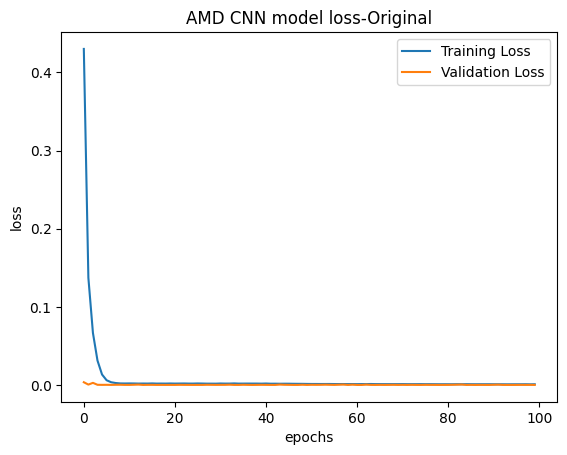

In [35]:
#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} CNN model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

##### Save model

In [38]:
# Save the entire model as a `.keras` zip archive.
# best_model.save('TSLA_model_hyperparameter.keras')
best_model.save(f'saved_model_CNN/{ticker}_model_{study_naam}')
# Save the weights
# model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
# model = create_model()

# Restore the weights
# model.load_weights('./checkpoints/my_checkpoint')

INFO:tensorflow:Assets written to: saved_model_CNN/AMD_model_Original/assets


INFO:tensorflow:Assets written to: saved_model_CNN/AMD_model_Original/assets


In [36]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 10, 64)            256       
                                                                 
 batch_normalization (Batch  (None, 10, 64)            256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 10, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 10, 64)            12352     
                                                                 
 dropout_1 (Dropout)         (None, 10, 64)            0         
                                                                 
 batch_normalization_1 (Bat  (None, 10, 64)            256       
 chNormalization)                                       

##### Load model

In [ ]:
new_model = tf.keras.models.load_model('TSLA_model_hyperparameter.keras')

##### Plot 

In [37]:
if attn:
    a = "attention"
else:
    a = ""

print("****************************TEST************************************")
# plot_simple(stock_data,"test",f'Stock Price(Test) Prediction with CNN({a})',ticker,y_raw, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'Stock Price(Test) Prediction with CNN({a})',ticker,y_raw, predicted_stock_price_raw)

****************************TEST************************************


In [ ]:
plot_comparison(y_test,predicted_stock_price_raw)

#### AMD - Filtered(SMA)

##### Start Tuning

The file 'AMD_data.csv' does exist.
Filter Name- SMA


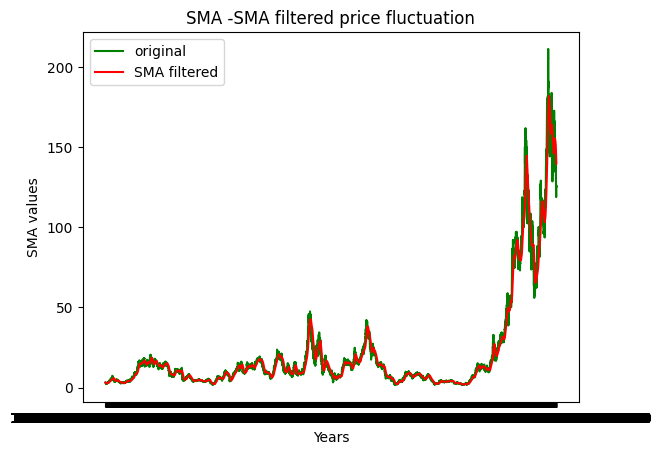

In [39]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=50
ticker="AMD" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="SMA" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="SMA"
sma_win = 50 #Re run
tuning=False
stock_file_name=f"{ticker}_data.csv"
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning)

##### After hyperparameter tuning - Train model with best values

win_size=50

In [40]:
win_size= 10#study_cnn.best_trial.params['win_size']
epoch_no= 100#study_cnn.best_trial.params['epoch_no']
drop_out= 0.4#round(study_cnn.best_trial.params['drop_out'],2)
units= 30#study_cnn.best_trial.params['units']
split_size= 0.4#round(study_cnn.best_trial.params['split_size'],2)
optimizer_options ='nadam'#study_cnn.best_trial.params['optimizer_name']
num_of_layers= 2#study_cnn.best_trial.params['no_layers']  
loss_option= 'log_cosh'#study_cnn.best_trial.params['loss_fn_name']
actv_option= 'gelu'#study_cnn.best_trial.params['activation_name']
filter_size= 64#study_cnn.best_trial.params['filter_size']
kernel_size= 3#study_cnn.best_trial.params['kernel_size']
# scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
best_model = build_model(win_size,drop_out,units,split_size,filter_size,kernel_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))

unscaled X_train size (6768, 10)
scaled X_train size (6768, 10, 1) (6768,)
Epoch 1/100
212/212 [==============================] - 4s 9ms/step - loss: 0.4974 - val_loss: 0.0034
Epoch 2/100
212/212 [==============================] - 2s 8ms/step - loss: 0.1446 - val_loss: 0.0025
Epoch 3/100
212/212 [==============================] - 2s 8ms/step - loss: 0.0662 - val_loss: 0.0015
Epoch 4/100
212/212 [==============================] - 2s 8ms/step - loss: 0.0303 - val_loss: 1.7217e-04
Epoch 5/100
212/212 [==============================] - 2s 8ms/step - loss: 0.0142 - val_loss: 5.5866e-04
Epoch 6/100
212/212 [==============================] - 2s 8ms/step - loss: 0.0068 - val_loss: 2.7525e-04
Epoch 7/100
212/212 [==============================] - 2s 8ms/step - loss: 0.0037 - val_loss: 5.5348e-05
Epoch 8/100
212/212 [==============================] - 2s 9ms/step - loss: 0.0025 - val_loss: 3.8166e-05
Epoch 9/100
212/212 [==============================] - 2s 9ms/step - loss: 0.0021 - val_loss: 4.6

##### Evalute tuned model

In [41]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

71/71 [==============================] - 0s 2ms/step
**********************SMA filter***************************
Mean Absolute Percentage Error (MAPE): 0.02%
Mean Absolute Error (MAE): 0.86
Root Mean Squared Error (RMSE): 1.35
R2 Score: 1.00


##### Validation and training loss plot

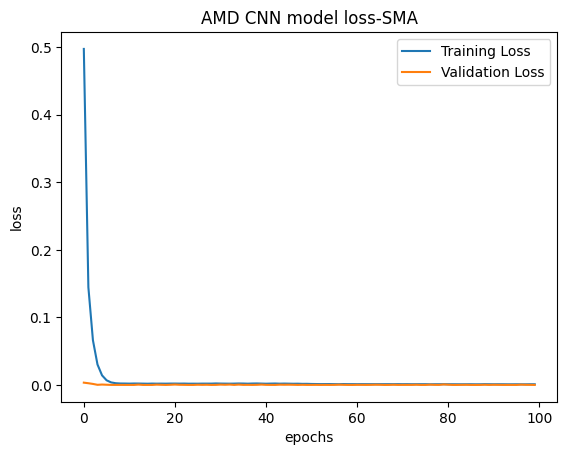

In [42]:

#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} CNN model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

##### Save model

In [45]:
# Save the entire model as a `.keras` zip archive.
best_model.save(f'saved_model_CNN/{ticker}_model_{study_naam}_{sma_win}')

# Save the weights
# model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
# model = create_model()

# Restore the weights
# model.load_weights('./checkpoints/my_checkpoint')

INFO:tensorflow:Assets written to: saved_model_CNN/AMD_model_SMA_50/assets


INFO:tensorflow:Assets written to: saved_model_CNN/AMD_model_SMA_50/assets


In [43]:
best_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 10, 64)            256       
                                                                 
 batch_normalization_3 (Bat  (None, 10, 64)            256       
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 10, 64)            0         
                                                                 
 conv1d_4 (Conv1D)           (None, 10, 64)            12352     
                                                                 
 dropout_5 (Dropout)         (None, 10, 64)            0         
                                                                 
 batch_normalization_4 (Bat  (None, 10, 64)            256       
 chNormalization)                                     

##### Load model

In [ ]:
new_model = tf.keras.models.load_model('TSLA_model_hyperparameter.keras')

##### Plot 

In [44]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['Close']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="CNN"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

****************************TEST************************************


#### AMD - Filtered(kalman)

##### Start Tuning

The file 'AMD_data.csv' does exist.
Filter Name- kalman


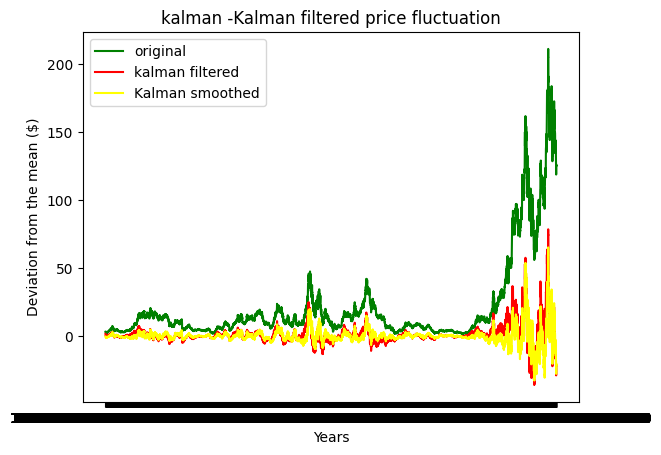

In [46]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=2
ticker="AMD" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="kalman" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="kalman"
tuning=False
stock_file_name=f"{ticker}_data.csv"
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning)

##### After hyperparameter tuning - Evaluate model with best values

In [48]:
win_size= 10#study_cnn.best_trial.params['win_size']
epoch_no= 100#study_cnn.best_trial.params['epoch_no']
drop_out= 0.4#round(study_cnn.best_trial.params['drop_out'],2)
units= 30#study_cnn.best_trial.params['units']
split_size= 0.4#round(study_cnn.best_trial.params['split_size'],2)
optimizer_options ='nadam'#study_cnn.best_trial.params['optimizer_name']
num_of_layers= 2#study_cnn.best_trial.params['no_layers']  
loss_option= 'log_cosh'#study_cnn.best_trial.params['loss_fn_name']
actv_option= 'gelu'#study_cnn.best_trial.params['activation_name']
filter_size= 64#study_cnn.best_trial.params['filter_size']
kernel_size= 3#study_cnn.best_trial.params['kernel_size']
# scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
best_model = build_model(win_size,drop_out,units,split_size,filter_size,kernel_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))

unscaled X_train size (6768, 10)
scaled X_train size (6768, 10, 1) (6768,)
Epoch 1/100
212/212 [==============================] - 4s 9ms/step - loss: 0.4910 - val_loss: 0.0240
Epoch 2/100
212/212 [==============================] - 2s 9ms/step - loss: 0.1412 - val_loss: 0.0149
Epoch 3/100
212/212 [==============================] - 2s 9ms/step - loss: 0.0644 - val_loss: 0.0050
Epoch 4/100
212/212 [==============================] - 2s 9ms/step - loss: 0.0294 - val_loss: 0.0013
Epoch 5/100
212/212 [==============================] - 2s 9ms/step - loss: 0.0128 - val_loss: 0.0011
Epoch 6/100
212/212 [==============================] - 2s 9ms/step - loss: 0.0059 - val_loss: 6.1157e-04
Epoch 7/100
212/212 [==============================] - 2s 9ms/step - loss: 0.0029 - val_loss: 3.7165e-04
Epoch 8/100
212/212 [==============================] - 2s 9ms/step - loss: 0.0017 - val_loss: 1.6872e-04
Epoch 9/100
212/212 [==============================] - 2s 9ms/step - loss: 0.0014 - val_loss: 1.1665e-04


##### Evaluate trained model

In [49]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

71/71 [==============================] - 0s 2ms/step
**********************kalman filter***************************
Mean Absolute Percentage Error (MAPE): 4.93%
Mean Absolute Error (MAE): 2.05
Root Mean Squared Error (RMSE): 3.12
R2 Score: 0.95


##### Val and training loss plot

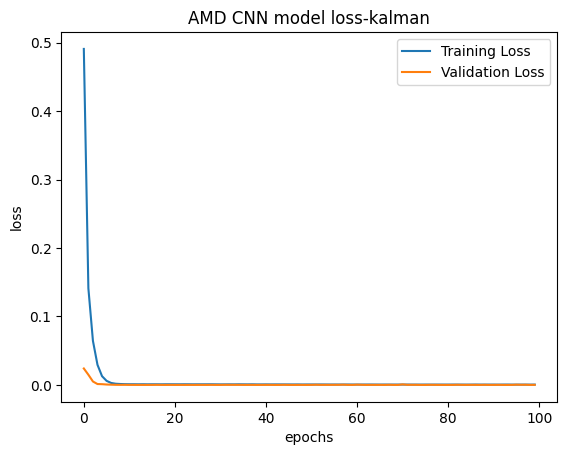

In [50]:

#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} CNN model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

##### Save model

In [52]:
# Save the entire model as a `.keras` zip archive.
best_model.save(f'saved_model_CNN/{ticker}_model_{study_naam}')

# Save the weights
# model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
# model = create_model()

# Restore the weights
# model.load_weights('./checkpoints/my_checkpoint')

INFO:tensorflow:Assets written to: saved_model_CNN/AMD_model_kalman/assets


INFO:tensorflow:Assets written to: saved_model_CNN/AMD_model_kalman/assets


##### Load model

In [ ]:
new_model = tf.keras.models.load_model('TSLA_model_hyperparameter.keras')

##### Plot 

In [51]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['Close']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="CNN"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

****************************TEST************************************


#### AMD - Filtered(EMA)

##### Start Tuning

The file 'AMD_data.csv' does exist.
Filter Name- EMA


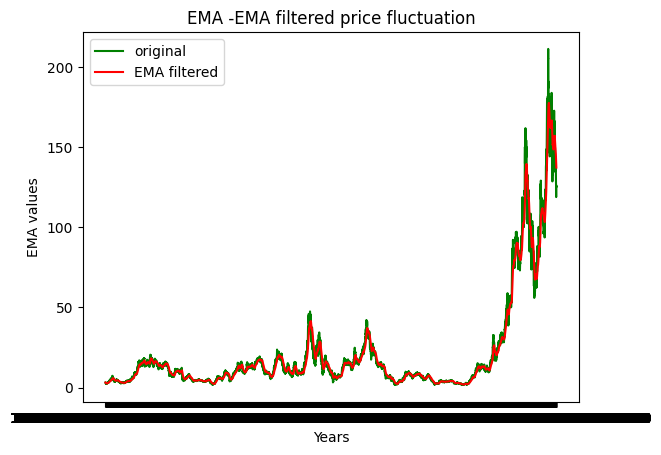

In [53]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
ema_win=50
n_trial=2
ticker="AMD" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="EMA" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="EMA"
tuning=False
stock_file_name=f"{ticker}_data.csv"
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning)

##### After hyperparameter tuning - Evaluate model with best values

In [55]:
win_size= 10#study_cnn.best_trial.params['win_size']
epoch_no= 100#study_cnn.best_trial.params['epoch_no']
drop_out= 0.4#round(study_cnn.best_trial.params['drop_out'],2)
units= 30#study_cnn.best_trial.params['units']
split_size= 0.4#round(study_cnn.best_trial.params['split_size'],2)
optimizer_options ='nadam'#study_cnn.best_trial.params['optimizer_name']
num_of_layers= 2#study_cnn.best_trial.params['no_layers']  
loss_option= 'mean_squared_error'#study_cnn.best_trial.params['loss_fn_name']
actv_option= 'gelu'#study_cnn.best_trial.params['activation_name']
filter_size= 64#study_cnn.best_trial.params['filter_size']
kernel_size= 3#study_cnn.best_trial.params['kernel_size']
# scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
best_model = build_model(win_size,drop_out,units,split_size,filter_size,kernel_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))

unscaled X_train size (6768, 10)
scaled X_train size (6768, 10, 1) (6768,)
Epoch 1/100
212/212 [==============================] - 4s 9ms/step - loss: 2.0246 - val_loss: 0.0068
Epoch 2/100
212/212 [==============================] - 2s 9ms/step - loss: 0.6273 - val_loss: 0.0023
Epoch 3/100
212/212 [==============================] - 2s 9ms/step - loss: 0.3370 - val_loss: 0.0032
Epoch 4/100
212/212 [==============================] - 2s 9ms/step - loss: 0.2188 - val_loss: 0.0052
Epoch 5/100
212/212 [==============================] - 2s 8ms/step - loss: 0.1332 - val_loss: 0.0087
Epoch 6/100
212/212 [==============================] - 2s 9ms/step - loss: 0.0871 - val_loss: 9.1226e-05
Epoch 7/100
212/212 [==============================] - 2s 9ms/step - loss: 0.0613 - val_loss: 2.7431e-04
Epoch 8/100
212/212 [==============================] - 2s 9ms/step - loss: 0.0392 - val_loss: 7.4480e-04
Epoch 9/100
212/212 [==============================] - 2s 9ms/step - loss: 0.0249 - val_loss: 1.1466e-04


In [60]:
win_size= 10#study_cnn.best_trial.params['win_size']
epoch_no= 100#study_cnn.best_trial.params['epoch_no']
drop_out= 0.4#round(study_cnn.best_trial.params['drop_out'],2)
units= 30#study_cnn.best_trial.params['units']
split_size= 0.4#round(study_cnn.best_trial.params['split_size'],2)
optimizer_options ='nadam'#study_cnn.best_trial.params['optimizer_name']
num_of_layers= 2#study_cnn.best_trial.params['no_layers']  
loss_option= 'log_cosh'#study_cnn.best_trial.params['loss_fn_name']
actv_option= 'gelu'#study_cnn.best_trial.params['activation_name']
filter_size= 64#study_cnn.best_trial.params['filter_size']
kernel_size= 3#study_cnn.best_trial.params['kernel_size']
# scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
best_model = build_model(win_size,drop_out,units,split_size,filter_size,kernel_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))

unscaled X_train size (6768, 10)
scaled X_train size (6768, 10, 1) (6768,)
Epoch 1/100
212/212 [==============================] - 4s 9ms/step - loss: 0.4904 - val_loss: 0.0026
Epoch 2/100
212/212 [==============================] - 2s 9ms/step - loss: 0.1570 - val_loss: 0.0026
Epoch 3/100
212/212 [==============================] - 2s 9ms/step - loss: 0.0803 - val_loss: 3.3099e-04
Epoch 4/100
212/212 [==============================] - 2s 9ms/step - loss: 0.0363 - val_loss: 8.4324e-04
Epoch 5/100
212/212 [==============================] - 2s 9ms/step - loss: 0.0172 - val_loss: 1.4106e-04
Epoch 6/100
212/212 [==============================] - 2s 9ms/step - loss: 0.0080 - val_loss: 7.6805e-05
Epoch 7/100
212/212 [==============================] - 2s 9ms/step - loss: 0.0043 - val_loss: 5.8272e-05
Epoch 8/100
212/212 [==============================] - 2s 9ms/step - loss: 0.0029 - val_loss: 1.7841e-05
Epoch 9/100
212/212 [==============================] - 2s 8ms/step - loss: 0.0023 - val_loss:

##### Evaluate trained model

In [56]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

71/71 [==============================] - 0s 2ms/step
**********************EMA filter***************************
Mean Absolute Percentage Error (MAPE): 0.06%
Mean Absolute Error (MAE): 3.86
Root Mean Squared Error (RMSE): 4.96
R2 Score: 0.99


In [61]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

71/71 [==============================] - 0s 2ms/step
**********************EMA filter***************************
Mean Absolute Percentage Error (MAPE): 0.09%
Mean Absolute Error (MAE): 6.66
Root Mean Squared Error (RMSE): 8.82
R2 Score: 0.97


##### Val and training loss plot

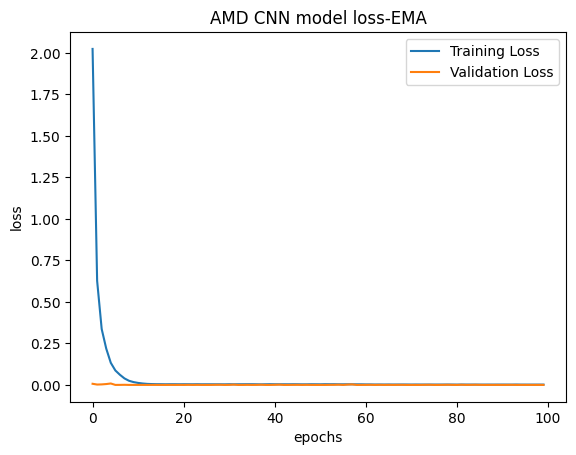

In [57]:

#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} CNN model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

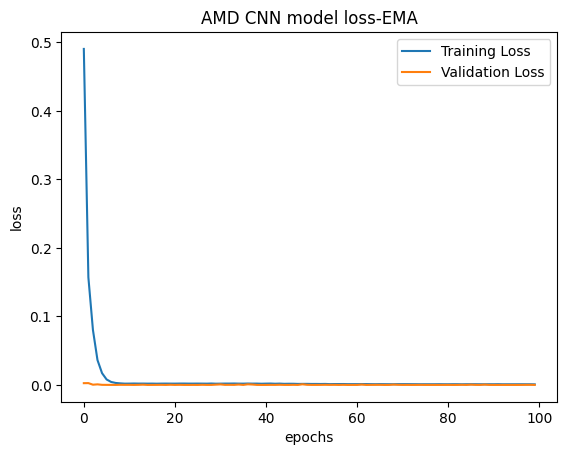

In [62]:

#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} CNN model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

##### Save model

In [58]:
# Save the entire model as a `.keras` zip archive.
best_model.save(f'saved_model_CNN/{ticker}_model_{study_naam}_{ema_win}')

# Save the weights
# model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
# model = create_model()

# Restore the weights
# model.load_weights('./checkpoints/my_checkpoint')

INFO:tensorflow:Assets written to: saved_model_CNN/AMD_model_EMA_50/assets


INFO:tensorflow:Assets written to: saved_model_CNN/AMD_model_EMA_50/assets


##### Load model

In [ ]:
new_model = tf.keras.models.load_model('TSLA_model_hyperparameter.keras')

##### Plot 

In [59]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['Close']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="CNN"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

****************************TEST************************************


In [63]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['Close']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="CNN"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

****************************TEST************************************


#### TSLA - Filtered(MACD)

##### Start Tuning

[I 2024-11-26 19:16:09,397] A new study created in memory with name: MACD


Filter Name- MACD
Epoch 1/10
91/91 [==============================] - 3s 14ms/step - loss: 0.0078 - val_loss: 0.0103
Epoch 2/10
91/91 [==============================] - 1s 8ms/step - loss: 0.0024 - val_loss: 0.0093
Epoch 3/10
91/91 [==============================] - 1s 8ms/step - loss: 0.0021 - val_loss: 0.0081
Epoch 4/10
91/91 [==============================] - 1s 8ms/step - loss: 0.0020 - val_loss: 0.0082
Epoch 5/10
91/91 [==============================] - 1s 8ms/step - loss: 0.0018 - val_loss: 0.0071
Epoch 6/10
91/91 [==============================] - 1s 8ms/step - loss: 0.0016 - val_loss: 0.0062
Epoch 7/10
91/91 [==============================] - 1s 8ms/step - loss: 0.0016 - val_loss: 0.0055
Epoch 8/10
91/91 [==============================] - 1s 8ms/step - loss: 0.0014 - val_loss: 0.0041
Epoch 9/10
91/91 [==============================] - 1s 8ms/step - loss: 0.0012 - val_loss: 0.0048
Epoch 10/10
91/91 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0033


[I 2024-11-26 19:16:20,064] Trial 0 finished with value: 0.0032991310581564903 and parameters: {'win_size': 20, 'epoch_no': 10, 'split_size': 0.2, 'units': 70, 'drop_out': 0.2}. Best is trial 0 with value: 0.0032991310581564903.


loss value [0.010338778607547283, 0.009312453679740429, 0.008104554377496243, 0.008184535428881645, 0.0070703160017728806, 0.006199487950652838, 0.005478709004819393, 0.0040875328704714775, 0.004820379428565502, 0.0032991310581564903]
Epoch 1/25
68/68 [==============================] - 4s 20ms/step - loss: 0.0092 - val_loss: 0.0087
Epoch 2/25
68/68 [==============================] - 1s 11ms/step - loss: 9.5575e-04 - val_loss: 0.0086
Epoch 3/25
68/68 [==============================] - 1s 12ms/step - loss: 8.2655e-04 - val_loss: 0.0088
Epoch 4/25
68/68 [==============================] - 1s 12ms/step - loss: 7.4906e-04 - val_loss: 0.0085
Epoch 5/25
68/68 [==============================] - 1s 12ms/step - loss: 6.9822e-04 - val_loss: 0.0087
Epoch 6/25
68/68 [==============================] - 1s 12ms/step - loss: 6.5303e-04 - val_loss: 0.0093
Epoch 7/25
68/68 [==============================] - 1s 11ms/step - loss: 6.2656e-04 - val_loss: 0.0092
Epoch 8/25
68/68 [==============================

[I 2024-11-26 19:16:35,230] Trial 1 finished with value: 0.008545308373868465 and parameters: {'win_size': 40, 'epoch_no': 25, 'split_size': 0.4, 'units': 70, 'drop_out': 0.2}. Best is trial 0 with value: 0.0032991310581564903.


loss value [0.008725729770958424, 0.008564658463001251, 0.008764608763158321, 0.008545308373868465, 0.008692014962434769, 0.009346519596874714, 0.009218539111316204, 0.01007468905299902, 0.009372632950544357, 0.009564652107656002, 0.009989520534873009, 0.010228118859231472, 0.010320046916604042, 0.010919501073658466]
Best parameters: for MACD filter {'win_size': 20, 'epoch_no': 10, 'split_size': 0.2, 'units': 70, 'drop_out': 0.2}
Best value: for MACD filter 0.0032991310581564903
    win_size: 20
    epoch_no: 10
    split_size: 0.2
    units: 70
    drop_out: 0.2


({'win_size': 20,
  'epoch_no': 10,
  'split_size': 0.2,
  'units': 70,
  'drop_out': 0.2},
 0.0032991310581564903)

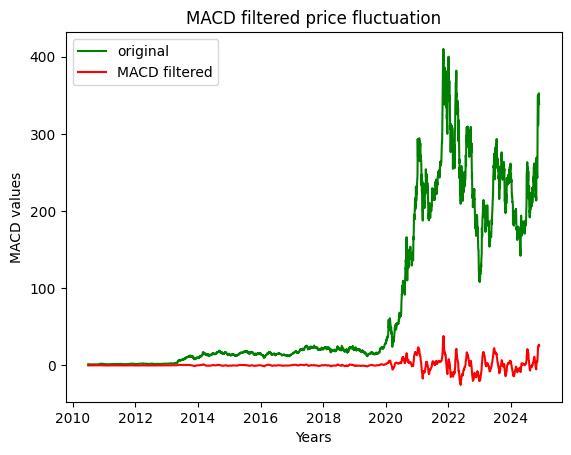

In [196]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=2
ticker="TSLA" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="MACD" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="MACD"
abc(ticker,n_trial,filter,f"{study_naam}",batch_size_no,attn)

##### Optuna plot

In [ ]:
optuna.visualization.plot_optimization_history(study_cnn)

In [ ]:
# optuna-dashboard sqlite:///db.sqlite3

optuna.visualization.plot_slice(study_cnn)

##### Best parameter values

In [ ]:
study_cnn.best_trial.params

{'win_size': 20,
 'epoch_no': 10,
 'split_size': 0.2,
 'units': 70,
 'drop_out': 0.2}

##### After hyperparameter tuning - Evaluate model with best values

In [ ]:
win_size=study_cnn.best_trial.params['win_size']
pred_step=10
epoch_no=study_cnn.best_trial.params['epoch_no']
batch_size_no=32
split_size=round(study_cnn.best_trial.params['split_size'],2)
attn=False
units=study_cnn.best_trial.params['units']
drop_out=round(study_cnn.best_trial.params['drop_out'],2)
n_trial=0
best_model = build_model(win_size,drop_out,units,split_size)
# print(f"**********************{study_naam} filter*************************")

scaled_data_unfilt = scaler.transform(tesla_data[['Close']].values)
X_unfilt,y_unfilt = create_sequences(scaled_data_unfilt,study_cnn.best_trial.params['win_size'])
X_test_unfilt = X_unfilt[-len(X_test):]
y_test_unfilt = y_unfilt[-len(y_test):]

history = best_model.fit(X_train, y_train, epochs=epoch_no, batch_size=32, validation_data=(X_test_unfilt, y_test_unfilt))
# abc("TSLA",win_size,pred_step,units,drop_out,n_trial,epoch_no,batch_size_no,split_size,attn)

Epoch 1/10
91/91 [==============================] - 3s 14ms/step - loss: 0.0100 - val_loss: 0.0096
Epoch 2/10
91/91 [==============================] - 1s 8ms/step - loss: 0.0020 - val_loss: 0.0080
Epoch 3/10
91/91 [==============================] - 1s 9ms/step - loss: 0.0019 - val_loss: 0.0063
Epoch 4/10
91/91 [==============================] - 1s 8ms/step - loss: 0.0018 - val_loss: 0.0053
Epoch 5/10
91/91 [==============================] - 1s 8ms/step - loss: 0.0015 - val_loss: 0.0043
Epoch 6/10
91/91 [==============================] - 1s 8ms/step - loss: 0.0014 - val_loss: 0.0037
Epoch 7/10
91/91 [==============================] - 1s 8ms/step - loss: 0.0012 - val_loss: 0.0035
Epoch 8/10
91/91 [==============================] - 1s 8ms/step - loss: 0.0012 - val_loss: 0.0028
Epoch 9/10
91/91 [==============================] - 1s 9ms/step - loss: 0.0010 - val_loss: 0.0026
Epoch 10/10
91/91 [==============================] - 1s 8ms/step - loss: 9.8636e-04 - val_loss: 0.0025


##### Evaluate trained model

In [ ]:
evaluate_model(best_model,X_test_unfilt,y_test_unfilt, filter)

23/23 [==============================] - 1s 3ms/step
**********************MACD filter***************************
Mean Absolute Percentage Error (MAPE): 1.92%
Mean Absolute Error (MAE): 2.41
Root Mean Squared Error (RMSE): 3.14
R2 Score: 0.91


##### Val and training loss plot

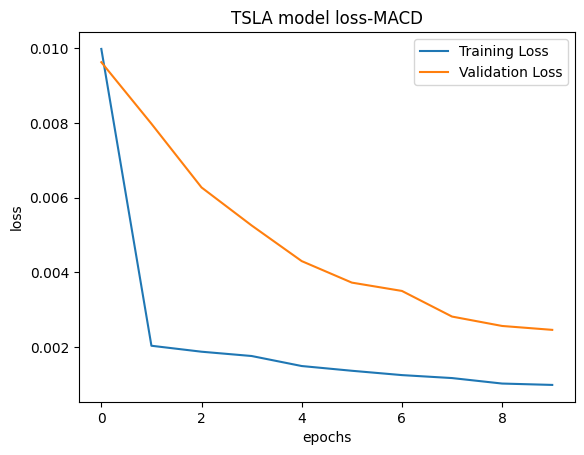

In [202]:
#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

##### Save model

In [ ]:
# Save the entire model as a `.keras` zip archive.
best_model.save(f'TSLA_model_hyperparameter_{filter}.keras')

# Save the weights
# model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
# model = create_model()

# Restore the weights
# model.load_weights('./checkpoints/my_checkpoint')

In [204]:
best_model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_40 (LSTM)              (None, 20, 70)            20160     
                                                                 
 dropout_40 (Dropout)        (None, 20, 70)            0         
                                                                 
 lstm_41 (LSTM)              (None, 70)                39480     
                                                                 
 dropout_41 (Dropout)        (None, 70)                0         
                                                                 
 dense_20 (Dense)            (None, 1)                 71        
                                                                 
Total params: 59711 (233.25 KB)
Trainable params: 59711 (233.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


##### Load model

In [ ]:
new_model = tf.keras.models.load_model('TSLA_model_hyperparameter.keras')

##### Plot 

****************************TEST************************************


<Figure size 1000x600 with 0 Axes>

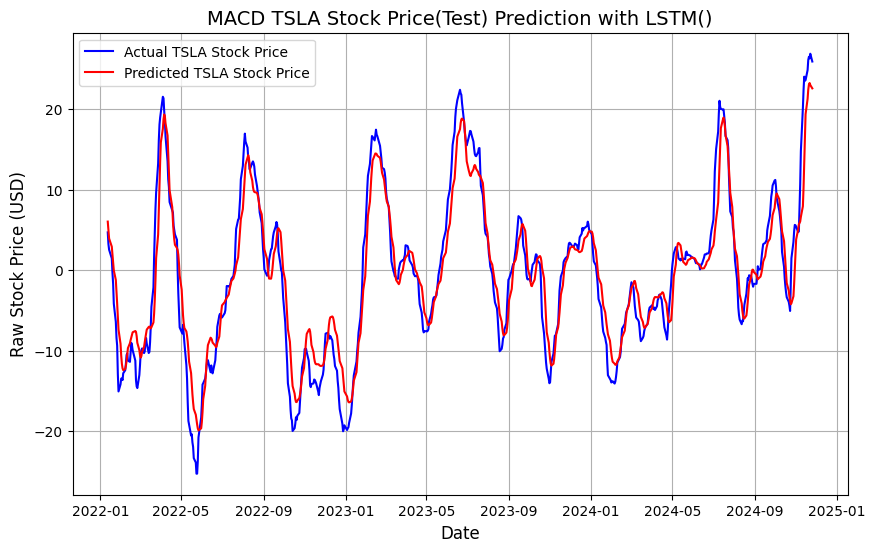

In [ ]:
if attn:
    a = "attention"
else:
    a = ""

print("****************************TEST************************************")
model_name="cnn"
plot_simple(tesla_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,y_raw, predicted_stock_price_raw,10,6)
plot_interative(tesla_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,y_raw, predicted_stock_price_raw)

#### AMD - Filtered(Fourier)

##### Start Tuning

The file 'AMD_data.csv' does exist.
freq- [ 0.00000000e+00  8.85661146e-05  1.77132229e-04 ... -2.65698344e-04
 -1.77132229e-04 -8.85661146e-05]
amp- [240325.29968715 102109.49488886 131204.85275027 ...  97117.10320762
 131204.85275027 102109.49488886]


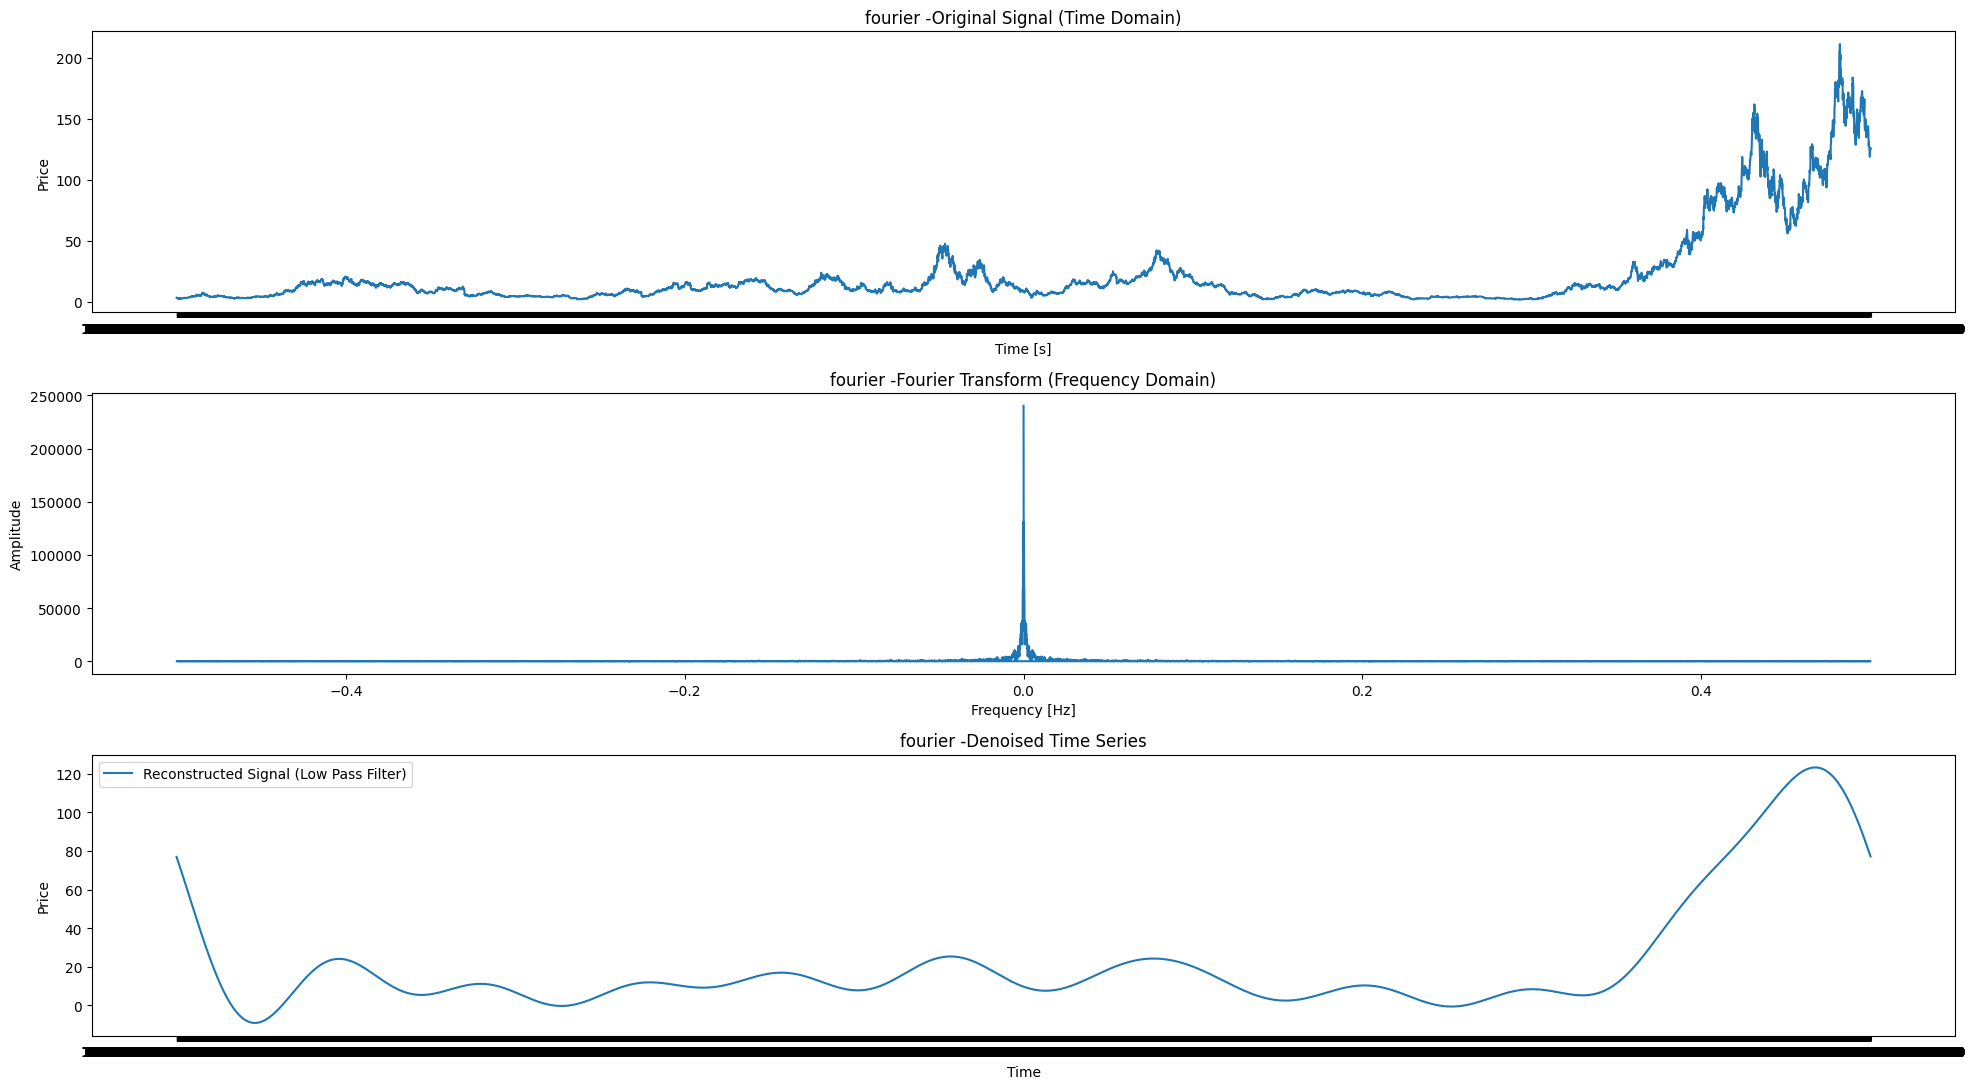

Filter Name- fourier


In [64]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=2
threshold = 0.001 #0.2, 0.1, 0.05, 0.01, 0.005, 0.001
ticker="AMD" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="fourier" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="fourier"
tuning=False
stock_file_name=f"{ticker}_data.csv"
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning)

The file 'AMD_data.csv' does exist.
freq- [ 0.00000000e+00  8.85661146e-05  1.77132229e-04 ... -2.65698344e-04
 -1.77132229e-04 -8.85661146e-05]
amp- [240325.29968715 102109.49488886 131204.85275027 ...  97117.10320762
 131204.85275027 102109.49488886]


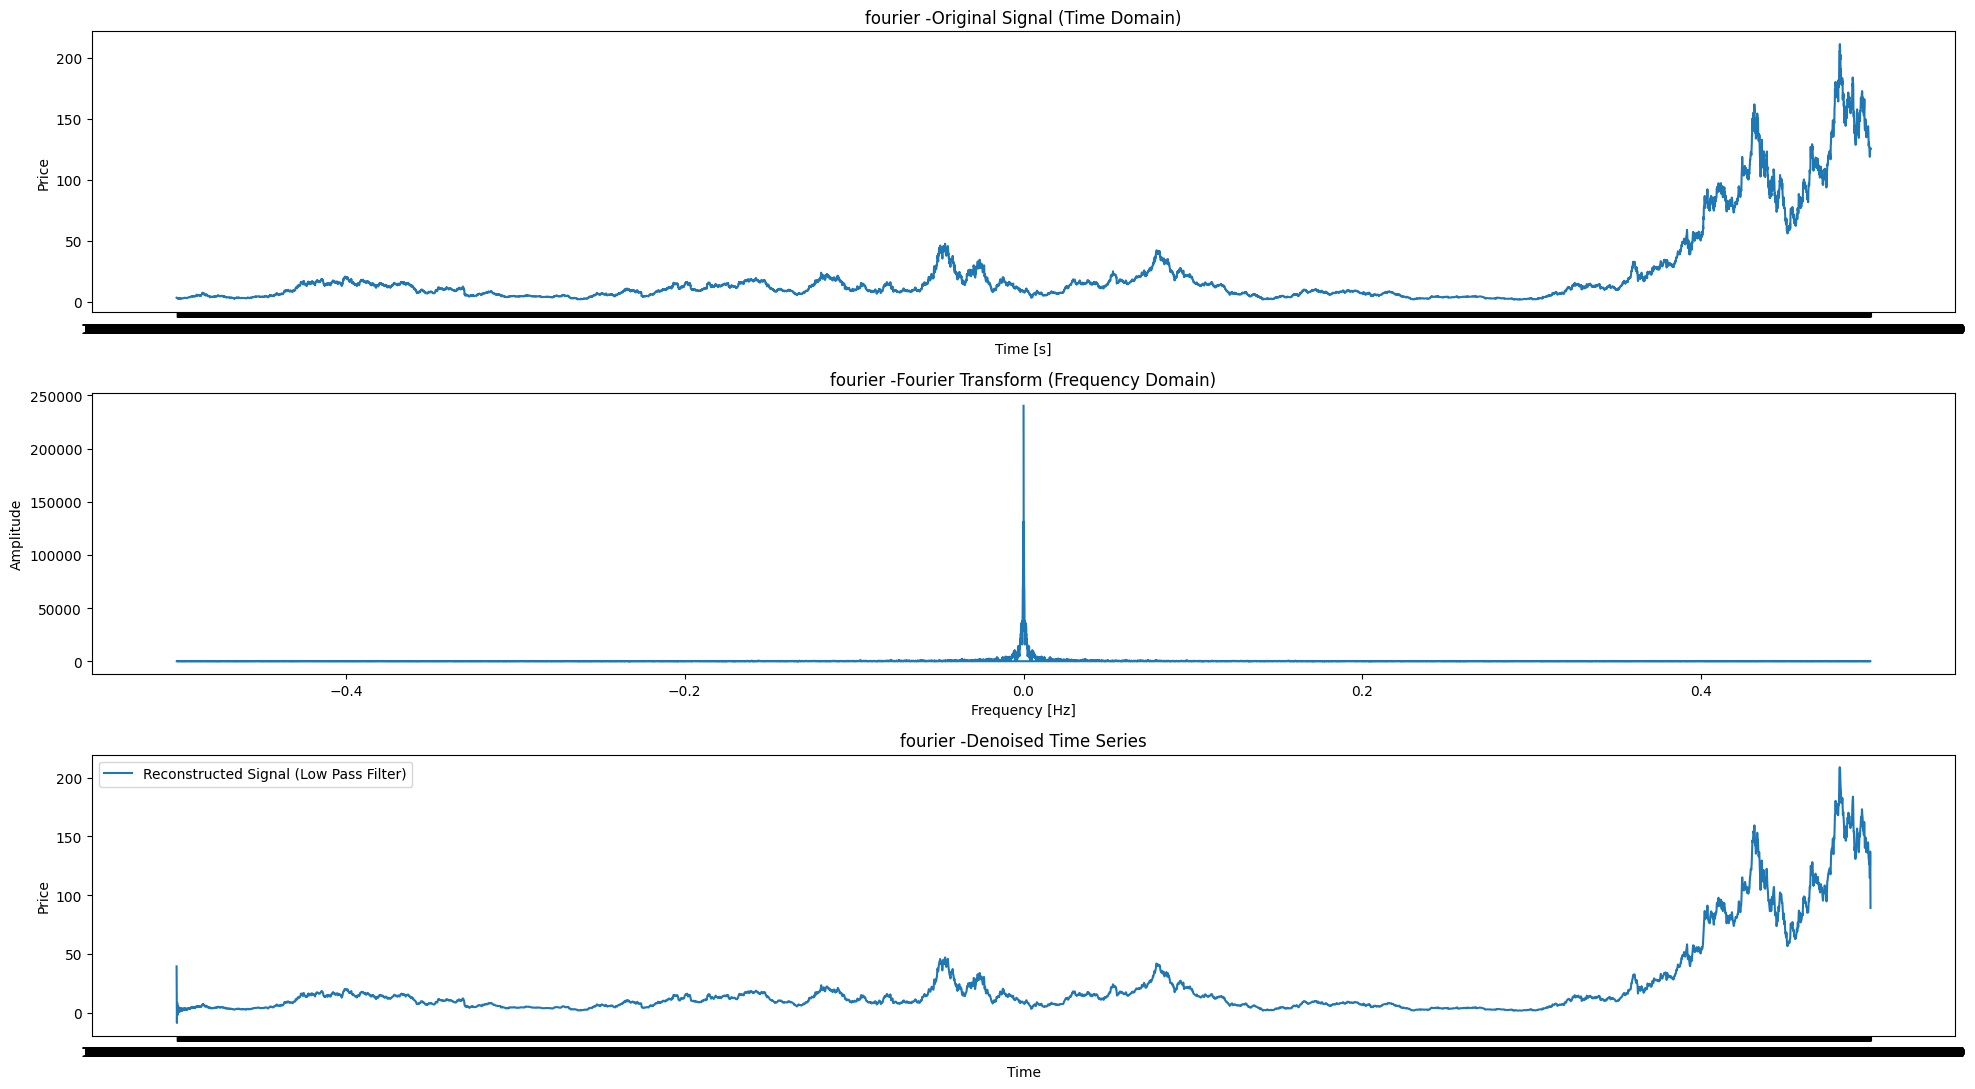

Filter Name- fourier


In [69]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=2
threshold = 0.2 #0.2, 0.1, 0.05, 0.01, 0.005, 0.001
ticker="AMD" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="fourier" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="fourier"
tuning=False
stock_file_name=f"{ticker}_data.csv"
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning)

##### After hyperparameter tuning - Train model with best values

In [65]:
win_size= 10#study_cnn.best_trial.params['win_size']
epoch_no= 100#study_cnn.best_trial.params['epoch_no']
drop_out= 0.4#round(study_cnn.best_trial.params['drop_out'],2)
units= 30#study_cnn.best_trial.params['units']
split_size= 0.4#round(study_cnn.best_trial.params['split_size'],2)
optimizer_options ='nadam'#study_cnn.best_trial.params['optimizer_name']
num_of_layers= 2#study_cnn.best_trial.params['no_layers']  
loss_option= 'mean_squared_error'#study_cnn.best_trial.params['loss_fn_name']
actv_option= 'gelu'#study_cnn.best_trial.params['activation_name']
filter_size= 64#study_cnn.best_trial.params['filter_size']
kernel_size= 3#study_cnn.best_trial.params['kernel_size']
# scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
best_model = build_model(win_size,drop_out,units,split_size,filter_size,kernel_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))

unscaled X_train size (6768, 10)
scaled X_train size (6768, 10, 1) (6768,)
Epoch 1/100
212/212 [==============================] - 5s 9ms/step - loss: 2.1933 - val_loss: 0.0121
Epoch 2/100
212/212 [==============================] - 2s 9ms/step - loss: 0.6773 - val_loss: 0.0070
Epoch 3/100
212/212 [==============================] - 2s 9ms/step - loss: 0.3403 - val_loss: 0.0017
Epoch 4/100
212/212 [==============================] - 2s 9ms/step - loss: 0.2100 - val_loss: 3.1140e-04
Epoch 5/100
212/212 [==============================] - 2s 9ms/step - loss: 0.1300 - val_loss: 0.0055
Epoch 6/100
212/212 [==============================] - 2s 9ms/step - loss: 0.0856 - val_loss: 0.0058
Epoch 7/100
212/212 [==============================] - 2s 9ms/step - loss: 0.0571 - val_loss: 0.0018
Epoch 8/100
212/212 [==============================] - 2s 9ms/step - loss: 0.0384 - val_loss: 3.3641e-04
Epoch 9/100
212/212 [==============================] - 2s 9ms/step - loss: 0.0234 - val_loss: 3.2273e-04
Epoc

In [70]:
win_size= 10#study_cnn.best_trial.params['win_size']
epoch_no= 100#study_cnn.best_trial.params['epoch_no']
drop_out= 0.4#round(study_cnn.best_trial.params['drop_out'],2)
units= 30#study_cnn.best_trial.params['units']
split_size= 0.4#round(study_cnn.best_trial.params['split_size'],2)
optimizer_options ='nadam'#study_cnn.best_trial.params['optimizer_name']
num_of_layers= 2#study_cnn.best_trial.params['no_layers']  
loss_option= 'mean_squared_error'#study_cnn.best_trial.params['loss_fn_name']
actv_option= 'gelu'#study_cnn.best_trial.params['activation_name']
filter_size= 64#study_cnn.best_trial.params['filter_size']
kernel_size= 3#study_cnn.best_trial.params['kernel_size']
# scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
best_model = build_model(win_size,drop_out,units,split_size,filter_size,kernel_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))

unscaled X_train size (6768, 10)
scaled X_train size (6768, 10, 1) (6768,)
Epoch 1/100
212/212 [==============================] - 5s 10ms/step - loss: 1.5614 - val_loss: 0.0063
Epoch 2/100
212/212 [==============================] - 2s 9ms/step - loss: 0.4181 - val_loss: 0.0068
Epoch 3/100
212/212 [==============================] - 2s 9ms/step - loss: 0.2096 - val_loss: 0.0023
Epoch 4/100
212/212 [==============================] - 2s 9ms/step - loss: 0.1156 - val_loss: 0.0022
Epoch 5/100
212/212 [==============================] - 2s 9ms/step - loss: 0.0706 - val_loss: 0.0010
Epoch 6/100
212/212 [==============================] - 2s 9ms/step - loss: 0.0433 - val_loss: 7.4316e-04
Epoch 7/100
212/212 [==============================] - 2s 9ms/step - loss: 0.0273 - val_loss: 7.1022e-04
Epoch 8/100
212/212 [==============================] - 2s 8ms/step - loss: 0.0155 - val_loss: 6.2283e-04
Epoch 9/100
212/212 [==============================] - 2s 9ms/step - loss: 0.0105 - val_loss: 2.4324e-04

##### Evaluate trained model

In [66]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

71/71 [==============================] - 0s 2ms/step
**********************fourier filter***************************
Mean Absolute Percentage Error (MAPE): 0.07%
Mean Absolute Error (MAE): 3.10
Root Mean Squared Error (RMSE): 3.52
R2 Score: 0.99


In [71]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

71/71 [==============================] - 0s 2ms/step
**********************fourier filter***************************
Mean Absolute Percentage Error (MAPE): 0.08%
Mean Absolute Error (MAE): 5.53
Root Mean Squared Error (RMSE): 7.43
R2 Score: 0.98


##### Val and training loss plot

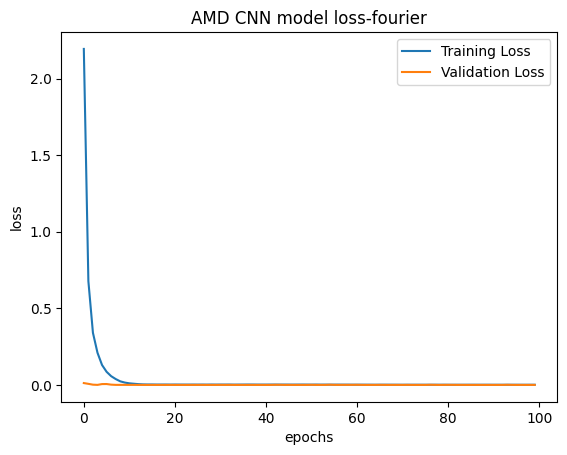

In [67]:

#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} CNN model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

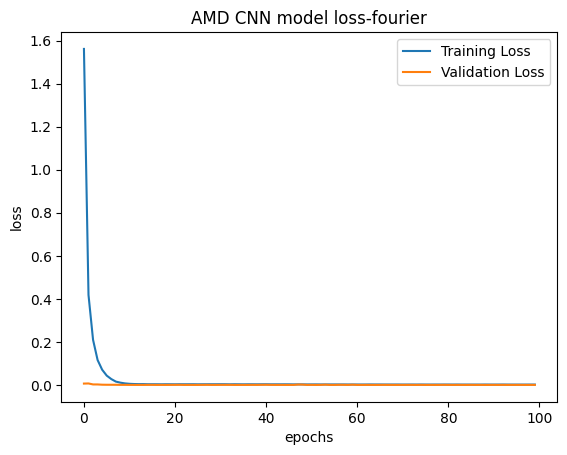

In [72]:

#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} CNN model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

##### Save model

In [74]:
# Save the entire model as a `.keras` zip archive.
best_model.save(f'saved_model_CNN/{ticker}_model_{study_naam}_{threshold}')

# Save the weights
# model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
# model = create_model()

# Restore the weights
# model.load_weights('./checkpoints/my_checkpoint')

INFO:tensorflow:Assets written to: saved_model_CNN/AMD_model_fourier_0.2/assets


INFO:tensorflow:Assets written to: saved_model_CNN/AMD_model_fourier_0.2/assets


In [ ]:
best_model.summary()

##### Load model

In [ ]:
new_model = tf.keras.models.load_model('TSLA_model_hyperparameter.keras')

##### Plot 

In [68]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['Close']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="CNN"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

****************************TEST************************************


In [73]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['Close']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="CNN"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

****************************TEST************************************


#### AMD - Filtered(Wavelet)

##### Start Tuning

The file 'AMD_data.csv' does exist.
length of details- 7
Threshold enabled- False


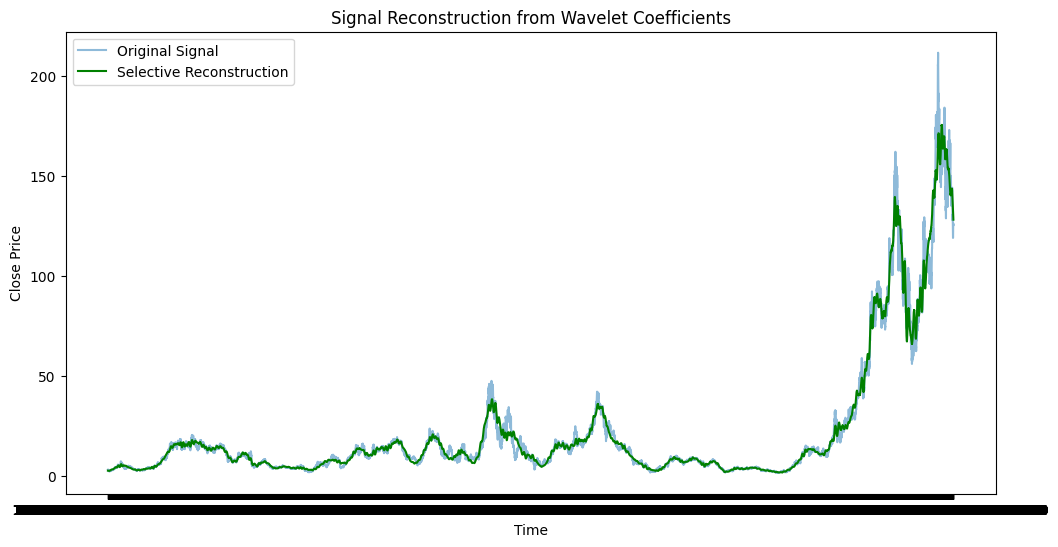

Filter Name- wavelet


In [106]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=2
ticker="AMD" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="wavelet" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="wavelet"
tuning=False
stock_file_name=f"{ticker}_data.csv"
detail_index=2
#'haar', 'db', 'sym', 'coif', 'bior', 'rbio', 'dmey', 'gaus',
# 'mexh', 'morl', 'cgau', 'shan', 'fbsp', 'cmor'
wavelet_name="dmey"
approx_enable=False
threshold_enable=False
thresh_value=0
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning,detail_index,wavelet_name,approx_enable,threshold_enable,thresh_value)

The file 'AMD_data.csv' does exist.
length of details- 7
Threshold enabled- False


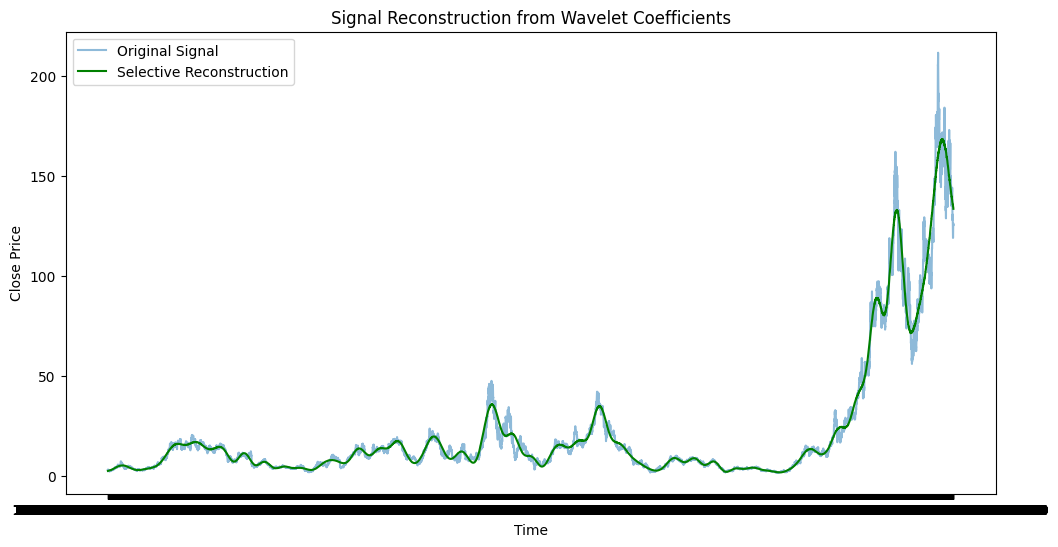

Filter Name- wavelet


In [112]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=2
ticker="AMD" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="wavelet" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="wavelet"
tuning=False
stock_file_name=f"{ticker}_data.csv"
detail_index=7
#'haar', 'db', 'sym', 'coif', 'bior', 'rbio', 'dmey', 'gaus',
# 'mexh', 'morl', 'cgau', 'shan', 'fbsp', 'cmor'
wavelet_name="dmey"
approx_enable=False
threshold_enable=False
thresh_value=0
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning,detail_index,wavelet_name,approx_enable,threshold_enable,thresh_value)

The file 'AMD_data.csv' does exist.
length of details- 8
Threshold enabled- False


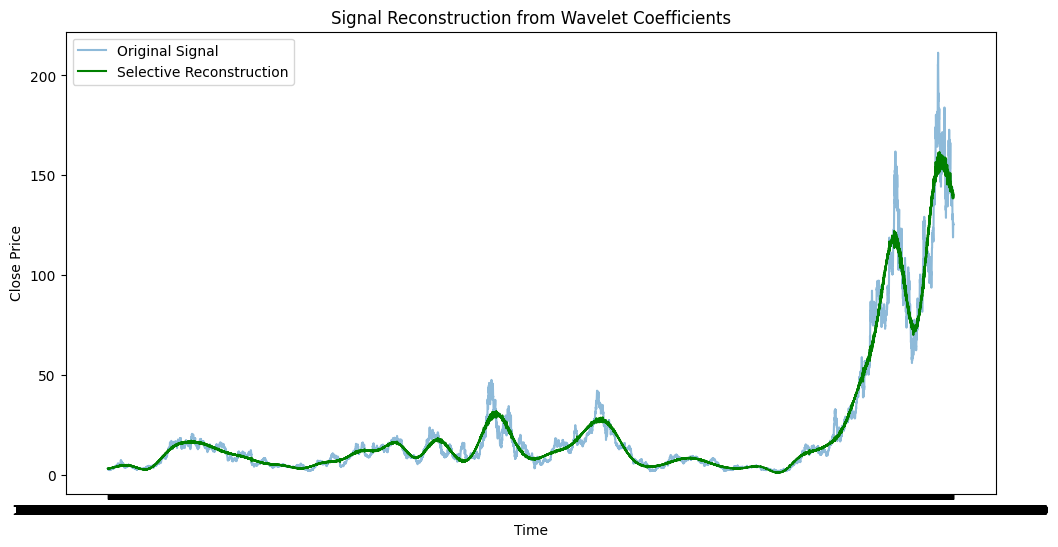

Filter Name- wavelet


In [126]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=2
ticker="AMD" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="wavelet" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="wavelet"
tuning=False
stock_file_name=f"{ticker}_data.csv"
detail_index=7
#'haar', 'db', 'sym', 'coif', 'bior', 'rbio', 'dmey', 'gaus',
# 'mexh', 'morl', 'cgau', 'shan', 'fbsp', 'cmor'
wavelet_name="sym18"
approx_enable=False
threshold_enable=False
thresh_value=0
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning,detail_index,wavelet_name,approx_enable,threshold_enable,thresh_value)

The file 'AMD_data.csv' does exist.
length of details- 8
Threshold enabled- False


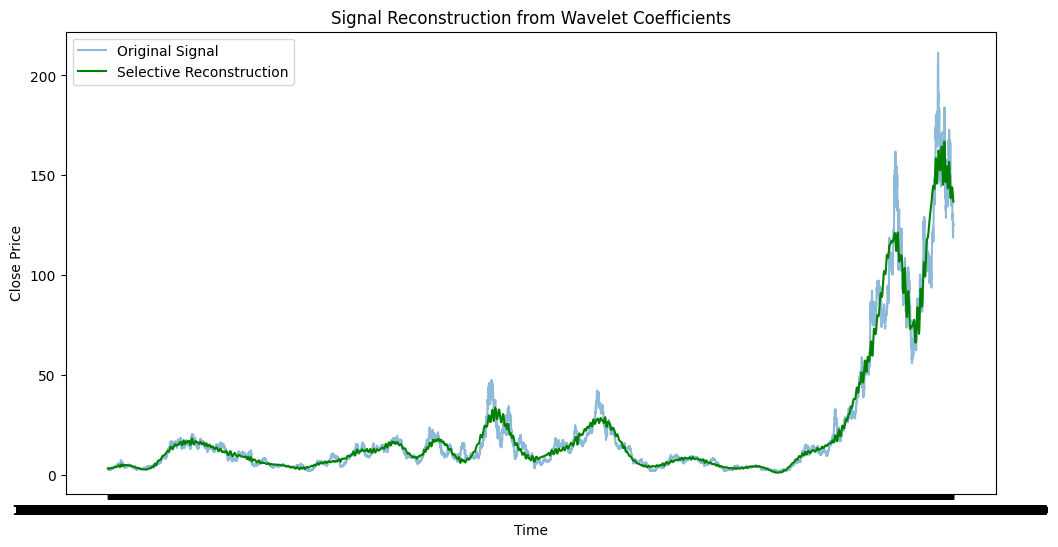

Filter Name- wavelet


In [130]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=2
ticker="AMD" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="wavelet" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="wavelet"
tuning=False
stock_file_name=f"{ticker}_data.csv"
detail_index=3
#'haar', 'db', 'sym', 'coif', 'bior', 'rbio', 'dmey', 'gaus',
# 'mexh', 'morl', 'cgau', 'shan', 'fbsp', 'cmor'
wavelet_name="sym18"
approx_enable=False
threshold_enable=False
thresh_value=0
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning,detail_index,wavelet_name,approx_enable,threshold_enable,thresh_value)

##### After hyperparameter tuning - Train model with best values

In [107]:
win_size= 10#study_cnn.best_trial.params['win_size']
epoch_no= 100#study_cnn.best_trial.params['epoch_no']
drop_out= 0.4#round(study_cnn.best_trial.params['drop_out'],2)
units= 30#study_cnn.best_trial.params['units']
split_size= 0.4#round(study_cnn.best_trial.params['split_size'],2)
optimizer_options ='nadam'#study_cnn.best_trial.params['optimizer_name']
num_of_layers= 2#study_cnn.best_trial.params['no_layers']  
loss_option= 'mean_squared_error'#study_cnn.best_trial.params['loss_fn_name']
actv_option= 'gelu'#study_cnn.best_trial.params['activation_name']
filter_size= 64#study_cnn.best_trial.params['filter_size']
kernel_size= 3#study_cnn.best_trial.params['kernel_size']

# scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
best_model = build_model(win_size,drop_out,units,split_size,filter_size,kernel_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))

unscaled X_train size (6769, 10)
scaled X_train size (6769, 10, 1) (6769,)
Epoch 1/100
212/212 [==============================] - 5s 10ms/step - loss: 2.8196 - val_loss: 0.0070
Epoch 2/100
212/212 [==============================] - 2s 8ms/step - loss: 0.8079 - val_loss: 0.0082
Epoch 3/100
212/212 [==============================] - 2s 8ms/step - loss: 0.4644 - val_loss: 0.0227
Epoch 4/100
212/212 [==============================] - 2s 8ms/step - loss: 0.2970 - val_loss: 0.0019
Epoch 5/100
212/212 [==============================] - 2s 8ms/step - loss: 0.1852 - val_loss: 0.0185
Epoch 6/100
212/212 [==============================] - 2s 8ms/step - loss: 0.1276 - val_loss: 0.0042
Epoch 7/100
212/212 [==============================] - 2s 8ms/step - loss: 0.0909 - val_loss: 0.0021
Epoch 8/100
212/212 [==============================] - 2s 8ms/step - loss: 0.0566 - val_loss: 2.1624e-04
Epoch 9/100
212/212 [==============================] - 2s 9ms/step - loss: 0.0416 - val_loss: 6.1216e-04
Epoch 1

In [113]:
win_size= 10#study_cnn.best_trial.params['win_size']
epoch_no= 100#study_cnn.best_trial.params['epoch_no']
drop_out= 0.4#round(study_cnn.best_trial.params['drop_out'],2)
units= 30#study_cnn.best_trial.params['units']
split_size= 0.4#round(study_cnn.best_trial.params['split_size'],2)
optimizer_options ='nadam'#study_cnn.best_trial.params['optimizer_name']
num_of_layers= 2#study_cnn.best_trial.params['no_layers']  
loss_option= 'mean_squared_error'#study_cnn.best_trial.params['loss_fn_name']
actv_option= 'gelu'#study_cnn.best_trial.params['activation_name']
filter_size= 64#study_cnn.best_trial.params['filter_size']
kernel_size= 3#study_cnn.best_trial.params['kernel_size']

# scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
best_model = build_model(win_size,drop_out,units,split_size,filter_size,kernel_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))

unscaled X_train size (6769, 10)
scaled X_train size (6769, 10, 1) (6769,)
Epoch 1/100
212/212 [==============================] - 4s 9ms/step - loss: 1.9643 - val_loss: 0.0112
Epoch 2/100
212/212 [==============================] - 2s 9ms/step - loss: 0.5814 - val_loss: 0.0043
Epoch 3/100
212/212 [==============================] - 2s 9ms/step - loss: 0.2932 - val_loss: 0.0022
Epoch 4/100
212/212 [==============================] - 2s 9ms/step - loss: 0.1701 - val_loss: 0.0013
Epoch 5/100
212/212 [==============================] - 2s 8ms/step - loss: 0.1088 - val_loss: 7.4854e-04
Epoch 6/100
212/212 [==============================] - 2s 9ms/step - loss: 0.0671 - val_loss: 0.0025
Epoch 7/100
212/212 [==============================] - 2s 9ms/step - loss: 0.0451 - val_loss: 3.1673e-04
Epoch 8/100
212/212 [==============================] - 2s 9ms/step - loss: 0.0295 - val_loss: 0.0016
Epoch 9/100
212/212 [==============================] - 2s 9ms/step - loss: 0.0198 - val_loss: 1.8585e-04
Epoc

In [127]:
win_size= 10#study_cnn.best_trial.params['win_size']
epoch_no= 100#study_cnn.best_trial.params['epoch_no']
drop_out= 0.4#round(study_cnn.best_trial.params['drop_out'],2)
units= 30#study_cnn.best_trial.params['units']
split_size= 0.4#round(study_cnn.best_trial.params['split_size'],2)
optimizer_options ='nadam'#study_cnn.best_trial.params['optimizer_name']
num_of_layers= 2#study_cnn.best_trial.params['no_layers']  
loss_option= 'mean_squared_error'#study_cnn.best_trial.params['loss_fn_name']
actv_option= 'gelu'#study_cnn.best_trial.params['activation_name']
filter_size= 64#study_cnn.best_trial.params['filter_size']
kernel_size= 3#study_cnn.best_trial.params['kernel_size']

# scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
best_model = build_model(win_size,drop_out,units,split_size,filter_size,kernel_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))

unscaled X_train size (6769, 10)
scaled X_train size (6769, 10, 1) (6769,)
Epoch 1/100
212/212 [==============================] - 4s 9ms/step - loss: 2.2854 - val_loss: 0.0137
Epoch 2/100
212/212 [==============================] - 2s 8ms/step - loss: 0.6304 - val_loss: 0.0095
Epoch 3/100
212/212 [==============================] - 2s 9ms/step - loss: 0.3468 - val_loss: 0.0091
Epoch 4/100
212/212 [==============================] - 2s 9ms/step - loss: 0.2089 - val_loss: 0.0034
Epoch 5/100
212/212 [==============================] - 2s 9ms/step - loss: 0.1343 - val_loss: 0.0041
Epoch 6/100
212/212 [==============================] - 2s 9ms/step - loss: 0.0798 - val_loss: 0.0027
Epoch 7/100
212/212 [==============================] - 2s 8ms/step - loss: 0.0517 - val_loss: 4.5521e-04
Epoch 8/100
212/212 [==============================] - 2s 9ms/step - loss: 0.0359 - val_loss: 0.0026
Epoch 9/100
212/212 [==============================] - 2s 9ms/step - loss: 0.0237 - val_loss: 2.5056e-04
Epoch 10

In [131]:
win_size= 10#study_cnn.best_trial.params['win_size']
epoch_no= 100#study_cnn.best_trial.params['epoch_no']
drop_out= 0.4#round(study_cnn.best_trial.params['drop_out'],2)
units= 30#study_cnn.best_trial.params['units']
split_size= 0.4#round(study_cnn.best_trial.params['split_size'],2)
optimizer_options ='nadam'#study_cnn.best_trial.params['optimizer_name']
num_of_layers= 2#study_cnn.best_trial.params['no_layers']  
loss_option= 'mean_squared_error'#study_cnn.best_trial.params['loss_fn_name']
actv_option= 'gelu'#study_cnn.best_trial.params['activation_name']
filter_size= 64#study_cnn.best_trial.params['filter_size']
kernel_size= 3#study_cnn.best_trial.params['kernel_size']

# scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
best_model = build_model(win_size,drop_out,units,split_size,filter_size,kernel_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))

unscaled X_train size (6769, 10)
scaled X_train size (6769, 10, 1) (6769,)
Epoch 1/100
212/212 [==============================] - 5s 9ms/step - loss: 1.3327 - val_loss: 0.0092
Epoch 2/100
212/212 [==============================] - 2s 9ms/step - loss: 0.3433 - val_loss: 0.0029
Epoch 3/100
212/212 [==============================] - 2s 9ms/step - loss: 0.1807 - val_loss: 0.0011
Epoch 4/100
212/212 [==============================] - 2s 9ms/step - loss: 0.1017 - val_loss: 4.1427e-04
Epoch 5/100
212/212 [==============================] - 2s 8ms/step - loss: 0.0570 - val_loss: 2.1421e-04
Epoch 6/100
212/212 [==============================] - 2s 9ms/step - loss: 0.0356 - val_loss: 0.0012
Epoch 7/100
212/212 [==============================] - 2s 9ms/step - loss: 0.0230 - val_loss: 3.7597e-04
Epoch 8/100
212/212 [==============================] - 2s 9ms/step - loss: 0.0140 - val_loss: 8.0385e-05
Epoch 9/100
212/212 [==============================] - 2s 9ms/step - loss: 0.0101 - val_loss: 1.7467e

##### Evaluate trained model

In [108]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

71/71 [==============================] - 0s 2ms/step
**********************wavelet filter***************************
Mean Absolute Percentage Error (MAPE): 0.07%
Mean Absolute Error (MAE): 4.58
Root Mean Squared Error (RMSE): 5.92
R2 Score: 0.99


In [114]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

71/71 [==============================] - 0s 2ms/step
**********************wavelet filter***************************
Mean Absolute Percentage Error (MAPE): 0.03%
Mean Absolute Error (MAE): 0.93
Root Mean Squared Error (RMSE): 1.40
R2 Score: 1.00


In [128]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

71/71 [==============================] - 0s 2ms/step
**********************wavelet filter***************************
Mean Absolute Percentage Error (MAPE): 0.07%
Mean Absolute Error (MAE): 4.74
Root Mean Squared Error (RMSE): 6.14
R2 Score: 0.98


In [132]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

71/71 [==============================] - 0s 2ms/step
**********************wavelet filter***************************
Mean Absolute Percentage Error (MAPE): 0.11%
Mean Absolute Error (MAE): 8.34
Root Mean Squared Error (RMSE): 10.93
R2 Score: 0.95


##### Val and training loss plot

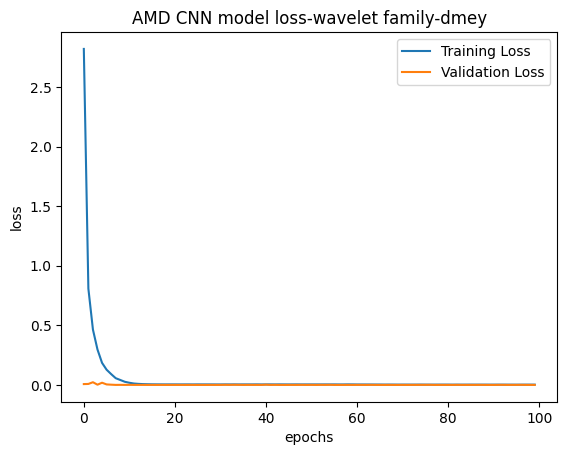

In [109]:

#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} CNN model loss-{study_naam} family-{wavelet_name}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

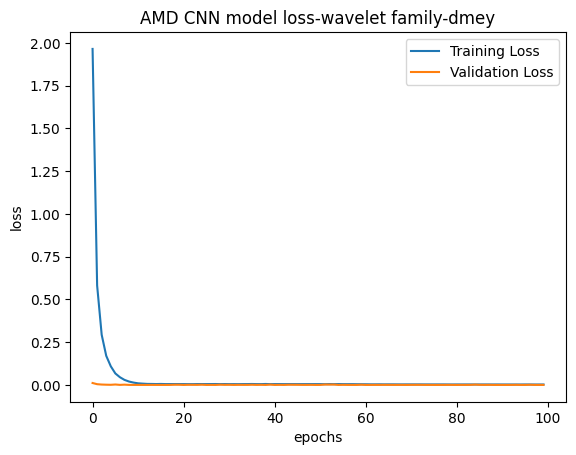

In [117]:

#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} CNN model loss-{study_naam} family-{wavelet_name}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

##### Save model

In [116]:
# Save the entire model as a `.keras` zip archive.
best_model.save(f'saved_model_CNN/{ticker}_model_{study_naam}_{wavelet_name}({detail_index})')

# Save the weights
# model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
# model = create_model()

# Restore the weights
# model.load_weights('./checkpoints/my_checkpoint')

INFO:tensorflow:Assets written to: saved_model_CNN/AMD_model_wavelet_dmey(7)/assets


INFO:tensorflow:Assets written to: saved_model_CNN/AMD_model_wavelet_dmey(7)/assets


In [57]:
best_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 30, 70)            20160     
                                                                 
 dropout_4 (Dropout)         (None, 30, 70)            0         
                                                                 
 lstm_5 (LSTM)               (None, 70)                39480     
                                                                 
 dropout_5 (Dropout)         (None, 70)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 71        
                                                                 
Total params: 59711 (233.25 KB)
Trainable params: 59711 (233.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


##### Load model

In [ ]:
new_model = tf.keras.models.load_model('TSLA_model_hyperparameter.keras')

##### Plot 

In [110]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['Close']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="CNN"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

****************************TEST************************************


In [115]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['Close']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="CNN"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

****************************TEST************************************


In [129]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['Close']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="CNN"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

****************************TEST************************************


In [133]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['Close']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="CNN"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

****************************TEST************************************


#### TSLA - Filtered(STL)

##### Start Tuning

In [31]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=2
ticker="TSLA" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="STL" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="STL"
detail_index=0
wavelet_name="db4"
approx_enable=True
threshold_enable=False
thresh_value=0
mstl_period=[7]
stl_period=30
abc(ticker,n_trial,filter,study_naam,batch_size_no,attn,detail_index,wavelet_name,approx_enable,threshold_enable,thresh_value,mstl_period,stl_period)

[I 2024-12-02 13:30:26,004] A new study created in memory with name: mstl


Epoch 1/5


2024-12-02 13:30:27.637341: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



79/79 [==============================] - 4s 18ms/step - loss: 0.3486 - val_loss: 0.2584
Epoch 2/5
79/79 [==============================] - 1s 9ms/step - loss: 0.0698 - val_loss: 0.3455
Epoch 3/5
79/79 [==============================] - 1s 9ms/step - loss: 0.0672 - val_loss: 0.0812
Epoch 4/5
79/79 [==============================] - 1s 9ms/step - loss: 0.0558 - val_loss: 0.1328
Epoch 5/5
79/79 [==============================] - 1s 9ms/step - loss: 0.0517 - val_loss: 21.5080


[I 2024-12-02 13:30:32,714] Trial 0 finished with value: 0.08116770535707474 and parameters: {'win_size': 20, 'epoch_no': 5, 'split_size': 0.30000000000000004, 'units': 50, 'drop_out': 0.5, 'filter_size': 64, 'kernel_size': 3}. Best is trial 0 with value: 0.08116770535707474.


loss value [0.258429616689682, 0.34553292393684387, 0.08116770535707474, 0.1328061819076538, 21.50798225402832]
Epoch 1/20


2024-12-02 13:30:34.071104: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-02 13:30:34.170083: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



91/91 [==============================] - 3s 15ms/step - loss: 0.1238 - val_loss: 0.2915
Epoch 2/20
91/91 [==============================] - 1s 9ms/step - loss: 0.0838 - val_loss: 0.2588
Epoch 3/20
91/91 [==============================] - 1s 9ms/step - loss: 0.0596 - val_loss: 0.2120
Epoch 4/20
91/91 [==============================] - 1s 9ms/step - loss: 0.0736 - val_loss: 0.0428
Epoch 5/20
91/91 [==============================] - 1s 9ms/step - loss: 0.0376 - val_loss: 0.0518
Epoch 6/20
91/91 [==============================] - 1s 9ms/step - loss: 0.0266 - val_loss: 1.4676
Epoch 7/20
91/91 [==============================] - 1s 8ms/step - loss: 0.0294 - val_loss: 0.6708
Epoch 8/20
91/91 [==============================] - 1s 8ms/step - loss: 0.0204 - val_loss: 13.8265
Epoch 9/20
91/91 [==============================] - 1s 9ms/step - loss: 0.0170 - val_loss: 3.5980
Epoch 10/20
91/91 [==============================] - 1s 8ms/step - loss: 0.0140 - val_loss: 54.2591
Epoch 11/20
91/91 [========

[I 2024-12-02 13:30:46,421] Trial 1 finished with value: 0.04281292110681534 and parameters: {'win_size': 20, 'epoch_no': 20, 'split_size': 0.2, 'units': 60, 'drop_out': 0.2, 'filter_size': 64, 'kernel_size': 3}. Best is trial 1 with value: 0.04281292110681534.


loss value [0.2915045917034149, 0.258821576833725, 0.21195577085018158, 0.04281292110681534, 0.051841720938682556, 1.4675626754760742, 0.6707903146743774, 13.8264741897583, 3.5980064868927, 54.259056091308594, 6.657013893127441, 50.10568618774414, 17.486520767211914, 11.158255577087402]
Best parameters: for mstl filter {'win_size': 20, 'epoch_no': 20, 'split_size': 0.2, 'units': 60, 'drop_out': 0.2, 'filter_size': 64, 'kernel_size': 3}
Best value: for mstl filter 0.04281292110681534
    win_size: 20
    epoch_no: 20
    split_size: 0.2
    units: 60
    drop_out: 0.2
    filter_size: 64
    kernel_size: 3


({'win_size': 20,
  'epoch_no': 20,
  'split_size': 0.2,
  'units': 60,
  'drop_out': 0.2,
  'filter_size': 64,
  'kernel_size': 3},
 0.04281292110681534)

##### Optuna plot

In [32]:
optuna.visualization.plot_optimization_history(study_cnn)

In [33]:
# optuna-dashboard sqlite:///db.sqlite3

optuna.visualization.plot_slice(study_cnn)

##### Best parameter values

In [34]:
study_cnn.best_trial.params

{'win_size': 20,
 'epoch_no': 20,
 'split_size': 0.2,
 'units': 60,
 'drop_out': 0.2,
 'filter_size': 64,
 'kernel_size': 3}

##### After hyperparameter tuning - Train model with best values

In [35]:
win_size=study_cnn.best_trial.params['win_size']
pred_step=10
epoch_no=study_cnn.best_trial.params['epoch_no']
batch_size_no=32
split_size=round(study_cnn.best_trial.params['split_size'],2)
attn=False
units=study_cnn.best_trial.params['units']
drop_out=round(study_cnn.best_trial.params['drop_out'],2)
n_trial=0
filter = study_cnn.best_trial.params['filter_size']
ker_size = study_cnn.best_trial.params['kernel_size']
best_model = build_model(win_size,drop_out,units,split_size,filter,ker_size)
# print(f"**********************{study_naam} filter*************************")

scaled_data_unfilt = scaler.transform(tesla_data[['Close']].values)
X_unfilt,y_unfilt = create_sequences(scaled_data_unfilt,study_cnn.best_trial.params['win_size'])
X_test_unfilt = X_unfilt[-len(X_test):]
y_test_unfilt = y_unfilt[-len(y_test):]

history = best_model.fit(X_train, y_train, epochs=epoch_no, batch_size=32, validation_data=(X_test_unfilt, y_test_unfilt))
# abc("TSLA",win_size,pred_step,units,drop_out,n_trial,epoch_no,batch_size_no,split_size,attn)

Epoch 1/20
91/91 [==============================] - 3s 10ms/step - loss: 0.2265 - val_loss: 0.3043
Epoch 2/20
91/91 [==============================] - 1s 8ms/step - loss: 0.0739 - val_loss: 0.3223
Epoch 3/20
91/91 [==============================] - 1s 8ms/step - loss: 0.0478 - val_loss: 0.2986
Epoch 4/20
91/91 [==============================] - 1s 8ms/step - loss: 0.0356 - val_loss: 0.0882
Epoch 5/20
91/91 [==============================] - 1s 8ms/step - loss: 0.0247 - val_loss: 0.0985
Epoch 6/20
91/91 [==============================] - 1s 8ms/step - loss: 0.0218 - val_loss: 0.0338
Epoch 7/20
91/91 [==============================] - 1s 8ms/step - loss: 0.0189 - val_loss: 0.0246
Epoch 8/20
91/91 [==============================] - 1s 8ms/step - loss: 0.0145 - val_loss: 0.0132
Epoch 9/20
91/91 [==============================] - 1s 8ms/step - loss: 0.0128 - val_loss: 0.0099
Epoch 10/20
91/91 [==============================] - 1s 8ms/step - loss: 0.0110 - val_loss: 0.0152
Epoch 11/20
91/91 

##### Evaluate trained model

In [36]:
X_test_unfilt.shape

(723, 20)

In [37]:
type(X_test_unfilt)

numpy.ndarray

In [38]:
X_test_unfilt

array([[0.78606591, 0.79087492, 0.76310185, ..., 0.90308238, 0.93867759,
        0.87513055],
       [0.79087492, 0.76310185, 0.79594778, ..., 0.93867759, 0.87513055,
        0.89049385],
       [0.76310185, 0.79594778, 0.85581792, ..., 0.87513055, 0.89049385,
        0.87423682],
       ...,
       [0.65978887, 0.65475856, 0.63509697, ..., 0.86437202, 0.89736266,
        0.86169084],
       [0.65475856, 0.63509697, 0.63287544, ..., 0.89736266, 0.86169084,
        0.86077163],
       [0.63509697, 0.63287544, 0.61719721, ..., 0.86169084, 0.86077163,
        0.84713618]])

In [39]:
# scaled_data_org = scaler.transform(tesla_data[['Close']].values)
# X_test,y_test = create_sequences(scaled_data_org,study_cnn.best_trial.params['win_size'])
evaluate_model(best_model,X_test_unfilt,y_test_unfilt, filter)

23/23 [==============================] - 0s 2ms/step
**********************64 filter***************************
Mean Absolute Percentage Error (MAPE): 0.08%
Mean Absolute Error (MAE): 17.10
Root Mean Squared Error (RMSE): 22.20
R2 Score: 0.82


##### Val and training loss plot

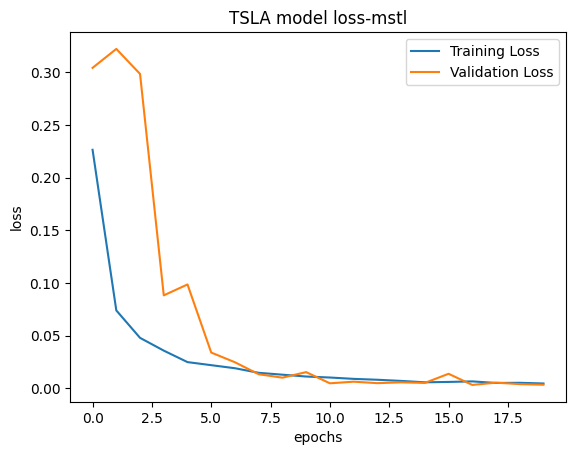

In [40]:
#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

##### Save model

In [ ]:
# Save the entire model as a `.keras` zip archive.
best_model.save(f'TSLA_model_hyperparameter_{filter}.keras')

# Save the weights
# model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
# model = create_model()

# Restore the weights
# model.load_weights('./checkpoints/my_checkpoint')

In [41]:
best_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_11 (Conv1D)          (None, 18, 64)            256       
                                                                 
 batch_normalization_10 (Ba  (None, 18, 64)            256       
 tchNormalization)                                               
                                                                 
 max_pooling1d_10 (MaxPooli  (None, 9, 64)             0         
 ng1D)                                                           
                                                                 
 conv1d_12 (Conv1D)          (None, 7, 64)             12352     
                                                                 
 batch_normalization_11 (Ba  (None, 7, 64)             256       
 tchNormalization)                                               
                                                      

##### Load model

In [ ]:
new_model = tf.keras.models.load_model('TSLA_model_hyperparameter.keras')

##### Plot 

****************************TEST************************************


<Figure size 1000x600 with 0 Axes>

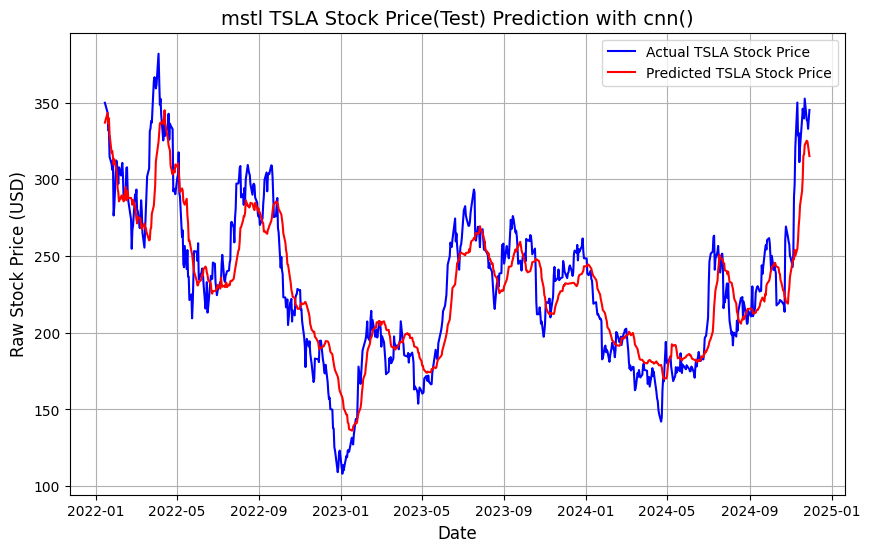

In [42]:
if attn:
    a = "attention"
else:
    a = ""

print("****************************TEST************************************")
model_name="cnn"
plot_simple(tesla_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,y_raw, predicted_stock_price_raw,10,6)
plot_interative(tesla_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,y_raw, predicted_stock_price_raw)

#### TSLA - Filtered(MSTL)

##### Start Tuning

In [51]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=2
ticker="TSLA" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="MSTL" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="MSTL"
detail_index=0
wavelet_name="db4"
approx_enable=True
threshold_enable=False
thresh_value=0
mstl_period=[7]
stl_period=30
abc(ticker,n_trial,filter,study_naam,batch_size_no,attn,detail_index,wavelet_name,approx_enable,threshold_enable,thresh_value,mstl_period,stl_period)

[I 2024-12-02 13:39:22,486] A new study created in memory with name: MSTL


                           filtered
Date                               
2010-06-29 00:00:00-04:00  1.384864
2010-06-30 00:00:00-04:00  1.354891
2010-07-01 00:00:00-04:00  1.334636
Epoch 1/25


2024-12-02 13:39:24.214836: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-02 13:39:24.369984: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-02 13:39:24.688138: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



16/90 [====>.........................] - ETA: 0s - loss: 0.0561 

2024-12-02 13:39:25.303459: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



90/90 [==============================] - 4s 16ms/step - loss: 0.1940 - val_loss: 0.1953
Epoch 2/25
90/90 [==============================] - 1s 8ms/step - loss: 0.0849 - val_loss: 0.2610
Epoch 3/25
90/90 [==============================] - 1s 8ms/step - loss: 0.0648 - val_loss: 0.1216
Epoch 4/25
90/90 [==============================] - 1s 8ms/step - loss: 0.0484 - val_loss: 0.0434
Epoch 5/25
90/90 [==============================] - 1s 8ms/step - loss: 0.0531 - val_loss: 1.5767
Epoch 6/25
90/90 [==============================] - 1s 9ms/step - loss: 0.0276 - val_loss: 7.0524
Epoch 7/25
90/90 [==============================] - 1s 9ms/step - loss: 0.0263 - val_loss: 36.0588
Epoch 8/25
90/90 [==============================] - 1s 8ms/step - loss: 0.0244 - val_loss: 9.8776
Epoch 9/25
90/90 [==============================] - 1s 8ms/step - loss: 0.0203 - val_loss: 16.6280
Epoch 10/25
90/90 [==============================] - 1s 8ms/step - loss: 0.0160 - val_loss: 48.2797
Epoch 11/25
90/90 [=======

[I 2024-12-02 13:39:36,615] Trial 0 finished with value: 0.04341466352343559 and parameters: {'win_size': 40, 'epoch_no': 25, 'split_size': 0.2, 'units': 60, 'drop_out': 0.2, 'filter_size': 16, 'kernel_size': 3}. Best is trial 0 with value: 0.04341466352343559.


loss value [0.1953336000442505, 0.2609606683254242, 0.12164448946714401, 0.04341466352343559, 1.5767498016357422, 7.052412986755371, 36.05884552001953, 9.877638816833496, 16.62801170349121, 48.27968978881836, 21.962846755981445, 7.311124324798584, 79.51514434814453, 12.7335844039917]
Epoch 1/20


2024-12-02 13:39:38.002149: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-02 13:39:38.104213: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



68/68 [==============================] - 3s 11ms/step - loss: 0.4491 - val_loss: 0.2135
Epoch 2/20
68/68 [==============================] - 1s 10ms/step - loss: 0.1283 - val_loss: 0.2399
Epoch 3/20
68/68 [==============================] - 1s 10ms/step - loss: 0.0126 - val_loss: 0.2506
Epoch 4/20
68/68 [==============================] - 1s 10ms/step - loss: 0.0025 - val_loss: 0.2455
Epoch 5/20
68/68 [==============================] - 1s 10ms/step - loss: 0.0014 - val_loss: 0.1368
Epoch 6/20
68/68 [==============================] - 1s 10ms/step - loss: 9.4690e-04 - val_loss: 0.0794
Epoch 7/20
68/68 [==============================] - 1s 10ms/step - loss: 6.2564e-04 - val_loss: 1.3777
Epoch 8/20
68/68 [==============================] - 1s 10ms/step - loss: 6.2077e-04 - val_loss: 15.8167
Epoch 9/20
68/68 [==============================] - 1s 10ms/step - loss: 5.7808e-04 - val_loss: 112.1434
Epoch 10/20
68/68 [==============================] - 1s 10ms/step - loss: 5.2671e-04 - val_loss: 523.

[I 2024-12-02 13:39:49,740] Trial 1 finished with value: 0.07939842343330383 and parameters: {'win_size': 30, 'epoch_no': 20, 'split_size': 0.4, 'units': 70, 'drop_out': 0.4, 'filter_size': 64, 'kernel_size': 3}. Best is trial 0 with value: 0.04341466352343559.


loss value [0.21353361010551453, 0.2398916333913803, 0.2506152093410492, 0.24546262621879578, 0.13677239418029785, 0.07939842343330383, 1.377701759338379, 15.816740036010742, 112.1434326171875, 523.5148315429688, 1022.0098266601562, 2326.70654296875, 3747.975341796875, 4393.3603515625, 5110.12646484375, 5450.2509765625]
Best parameters: for MSTL filter {'win_size': 40, 'epoch_no': 25, 'split_size': 0.2, 'units': 60, 'drop_out': 0.2, 'filter_size': 16, 'kernel_size': 3}
Best value: for MSTL filter 0.04341466352343559
    win_size: 40
    epoch_no: 25
    split_size: 0.2
    units: 60
    drop_out: 0.2
    filter_size: 16
    kernel_size: 3


({'win_size': 40,
  'epoch_no': 25,
  'split_size': 0.2,
  'units': 60,
  'drop_out': 0.2,
  'filter_size': 16,
  'kernel_size': 3},
 0.04341466352343559)

##### Optuna plot

In [52]:
optuna.visualization.plot_optimization_history(study_cnn)

In [53]:
# optuna-dashboard sqlite:///db.sqlite3

optuna.visualization.plot_slice(study_cnn)

##### Best parameter values

In [54]:
study_cnn.best_trial.params

{'win_size': 40,
 'epoch_no': 25,
 'split_size': 0.2,
 'units': 60,
 'drop_out': 0.2,
 'filter_size': 16,
 'kernel_size': 3}

##### After hyperparameter tuning - Train model with best values

In [55]:
win_size=study_cnn.best_trial.params['win_size']
pred_step=10
epoch_no=study_cnn.best_trial.params['epoch_no']
batch_size_no=32
split_size=round(study_cnn.best_trial.params['split_size'],2)
attn=False
units=study_cnn.best_trial.params['units']
drop_out=round(study_cnn.best_trial.params['drop_out'],2)
n_trial=0
filter = study_cnn.best_trial.params['filter_size']
ker_size = study_cnn.best_trial.params['kernel_size']
best_model = build_model(win_size,drop_out,units,split_size,filter,ker_size)
# print(f"**********************{study_naam} filter*************************")

scaled_data_unfilt = scaler.transform(tesla_data[['Close']].values)
X_unfilt,y_unfilt = create_sequences(scaled_data_unfilt,study_cnn.best_trial.params['win_size'])
X_test_unfilt = X_unfilt[-len(X_test):]
y_test_unfilt = y_unfilt[-len(y_test):]

history = best_model.fit(X_train, y_train, epochs=epoch_no, batch_size=32, validation_data=(X_test_unfilt, y_test_unfilt))
# abc("TSLA",win_size,pred_step,units,drop_out,n_trial,epoch_no,batch_size_no,split_size,attn)

Epoch 1/25
90/90 [==============================] - 3s 10ms/step - loss: 0.3969 - val_loss: 0.3830
Epoch 2/25
90/90 [==============================] - 1s 8ms/step - loss: 0.1515 - val_loss: 0.2929
Epoch 3/25
90/90 [==============================] - 1s 8ms/step - loss: 0.0888 - val_loss: 0.2221
Epoch 4/25
90/90 [==============================] - 1s 9ms/step - loss: 0.0678 - val_loss: 0.1485
Epoch 5/25
90/90 [==============================] - 1s 9ms/step - loss: 0.0468 - val_loss: 0.1872
Epoch 6/25
90/90 [==============================] - 1s 8ms/step - loss: 0.0367 - val_loss: 0.0339
Epoch 7/25
90/90 [==============================] - 1s 8ms/step - loss: 0.0321 - val_loss: 0.0115
Epoch 8/25
90/90 [==============================] - 1s 8ms/step - loss: 0.0255 - val_loss: 0.0227
Epoch 9/25
90/90 [==============================] - 1s 8ms/step - loss: 0.0225 - val_loss: 0.0162
Epoch 10/25
90/90 [==============================] - 1s 9ms/step - loss: 0.0201 - val_loss: 0.0396
Epoch 11/25
90/90 

##### Evaluate trained model

In [56]:
X_test_unfilt.shape

(719, 40)

In [57]:
type(X_test_unfilt)

numpy.ndarray

In [58]:
X_test_unfilt

array([[0.94106936, 0.94700189, 0.91799464, ..., 0.87423682, 0.84456565,
        0.84509336],
       [0.94700189, 0.91799464, 0.96486761, ..., 0.84456565, 0.84509336,
        0.80051849],
       [0.91799464, 0.96486761, 0.97148106, ..., 0.84509336, 0.80051849,
        0.78868748],
       ...,
       [0.65595868, 0.6329776 , 0.61163068, ..., 0.86437202, 0.89736266,
        0.86169084],
       [0.6329776 , 0.61163068, 0.63568426, ..., 0.89736266, 0.86169084,
        0.86077163],
       [0.61163068, 0.63568426, 0.61206477, ..., 0.86169084, 0.86077163,
        0.84713618]])

In [59]:
# scaled_data_org = scaler.transform(tesla_data[['Close']].values)
# X_test,y_test = create_sequences(scaled_data_org,study_cnn.best_trial.params['win_size'])
evaluate_model(best_model,X_test_unfilt,y_test_unfilt, filter)

23/23 [==============================] - 0s 2ms/step
**********************16 filter***************************
Mean Absolute Percentage Error (MAPE): 0.16%
Mean Absolute Error (MAE): 32.36
Root Mean Squared Error (RMSE): 39.34
R2 Score: 0.41


##### Val and training loss plot

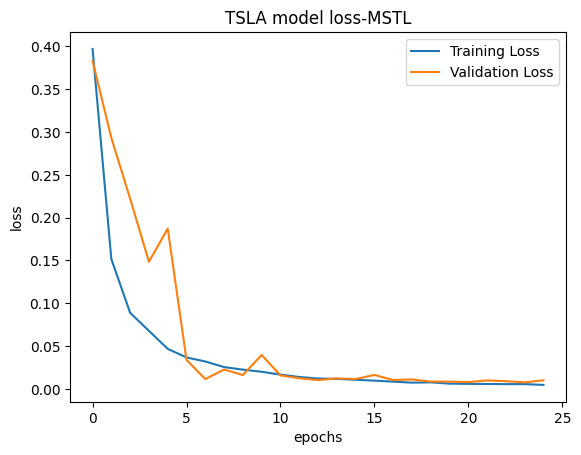

In [60]:
#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

##### Save model

In [ ]:
# Save the entire model as a `.keras` zip archive.
best_model.save(f'TSLA_model_hyperparameter_{filter}.keras')

# Save the weights
# model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
# model = create_model()

# Restore the weights
# model.load_weights('./checkpoints/my_checkpoint')

In [61]:
best_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_20 (Conv1D)          (None, 38, 16)            64        
                                                                 
 batch_normalization_19 (Ba  (None, 38, 16)            64        
 tchNormalization)                                               
                                                                 
 max_pooling1d_19 (MaxPooli  (None, 19, 16)            0         
 ng1D)                                                           
                                                                 
 conv1d_21 (Conv1D)          (None, 17, 16)            784       
                                                                 
 batch_normalization_20 (Ba  (None, 17, 16)            64        
 tchNormalization)                                               
                                                      

##### Load model

In [ ]:
new_model = tf.keras.models.load_model('TSLA_model_hyperparameter.keras')

##### Plot 

****************************TEST************************************


<Figure size 1000x600 with 0 Axes>

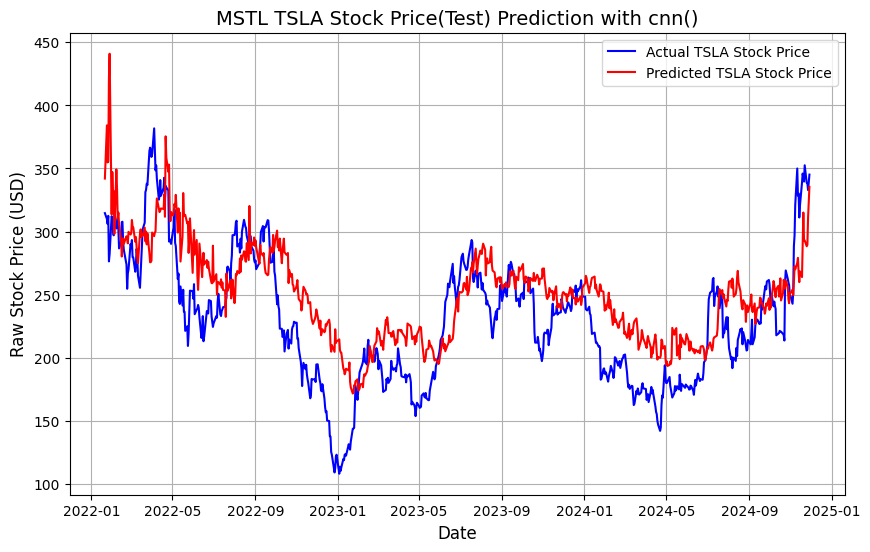

In [62]:
if attn:
    a = "attention"
else:
    a = ""

print("****************************TEST************************************")
model_name="cnn"
plot_simple(tesla_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,y_raw, predicted_stock_price_raw,10,6)
plot_interative(tesla_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,y_raw, predicted_stock_price_raw)

In [ ]:
rt_fft = tf.signal.fft(tesla_data['Close'])
fft = tf.signal.rfft(tesla_data[['Close']])
np.fft.fft(tesla_data['Close'])
recovered = tf.signal.ifft(rt_fft)
#plot tesla_data['Close] and recovered with x axis as tesla_data.index
plt.figure(figsize=(16,8))
plt.plot(tesla_data.index,tesla_data['Close'], label='Org Price', color='blue')
plt.plot(tesla_data.index,recovered, label='Rec Price', color='green')
plt.title('Tesla Stock Price')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()


In [72]:
len(tesla_data['Close'])

5534

In [ ]:
# import scipy.fft as fft
# # Generate a time-domain signal
# t = np.linspace(0, 1, 1000)
# x = np.sin(2 * np.pi * 10 * t) + np.sin(2 * np.pi * 20 * t)

# # Calculate the Fourier Transform
# X = fft.fft(tesla_data['Close'].values)
# freqs = fft.fftfreq(tesla_data['Close'].size,d=1)  # Calculate the frequencies

# from scipy import signal
# sos = signal.butter(2, 0.001, 'low', analog=False,output='sos')
# filtered = signal.sosfilt(sos, tesla_data[['Close']])
# # w, h = signal.freqs(b, a)

# # Plot the frequency-domain representation of the signal
# import matplotlib.pyplot as plt
# plt.plot(freqs, np.abs(X))
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Amplitude')
# plt.xlim([0, 50])  # Display frequencies from 0 to 50 Hz for clarity
# plt.show()

# #Plot the filtered data
# plt.figure(figsize=(10,6))
# plt.plot(tesla_data.index,filtered,label="filtered")
# plt.plot(tesla_data.index,tesla_data[['Close']],label="Actual")
# plt.title('Filtered Data')
# plt.xlabel('Time')
# plt.ylabel('Amplitude')
# plt.legend()
# plt.show()


#### AMD - Proposed Filter(hybrid) - Fourier_wavelet

In [30]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=2
ticker="AMD" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="hybrid" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="hybrid"
tuning=False
stock_file_name="AMD_autoencoder_data.csv"
detail_index=8
#'haar', 'db', 'sym', 'coif', 'bior', 'rbio', 'dmey', 'gaus',
# 'mexh', 'morl', 'cgau', 'shan', 'fbsp', 'cmor'
wavelet_name="dmey"
approx_enable=False
threshold_enable=False
thresh_value=0
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning,detail_index,wavelet_name,approx_enable,threshold_enable,thresh_value)

In [31]:
win_size= 10#study_cnn.best_trial.params['win_size']
epoch_no= 100#study_cnn.best_trial.params['epoch_no']
drop_out= 0.4#round(study_cnn.best_trial.params['drop_out'],2)
units= 30#study_cnn.best_trial.params['units']
split_size= 0.4#round(study_cnn.best_trial.params['split_size'],2)
optimizer_options ='nadam'#study_cnn.best_trial.params['optimizer_name']
num_of_layers= 2#study_cnn.best_trial.params['no_layers']  
loss_option= 'mean_squared_error'#study_cnn.best_trial.params['loss_fn_name']
actv_option= 'gelu'#study_cnn.best_trial.params['activation_name']
filter_size= 64#study_cnn.best_trial.params['filter_size']
kernel_size= 3#study_cnn.best_trial.params['kernel_size']

# scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
best_model = build_model(win_size,drop_out,units,split_size,filter_size,kernel_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))

unscaled X_train size (4194, 10)
scaled X_train size (4194, 10, 1) (4194,)


2025-01-08 12:31:58.842440: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1176 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:65:00.0, compute capability: 8.6


Epoch 1/100


2025-01-08 12:32:01.000869: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2025-01-08 12:32:01.084366: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2025-01-08 12:32:01.086933: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:225] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2025-01-08 12:32:01.086951: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:228] Used ptxas at ptxas
2025-01-08 12:32:01.087003: W external/local_xla/xla/stream_executor/gpu/redzone_allocator.cc:322] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2025-01-08 12:32

 22/132 [====>.........................] - ETA: 0s - loss: 4.7552  

2025-01-08 12:32:03.777604: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



132/132 [==============================] - 7s 15ms/step - loss: 2.3185 - val_loss: 0.4709
Epoch 2/100
132/132 [==============================] - 1s 9ms/step - loss: 0.7197 - val_loss: 0.3309
Epoch 3/100
132/132 [==============================] - 1s 9ms/step - loss: 0.3890 - val_loss: 0.1567
Epoch 4/100
132/132 [==============================] - 1s 9ms/step - loss: 0.2522 - val_loss: 0.0912
Epoch 5/100
132/132 [==============================] - 1s 9ms/step - loss: 0.1619 - val_loss: 0.0821
Epoch 6/100
132/132 [==============================] - 1s 9ms/step - loss: 0.1213 - val_loss: 0.0489
Epoch 7/100
132/132 [==============================] - 1s 9ms/step - loss: 0.0874 - val_loss: 0.0616
Epoch 8/100
132/132 [==============================] - 1s 8ms/step - loss: 0.0697 - val_loss: 0.0262
Epoch 9/100
132/132 [==============================] - 1s 9ms/step - loss: 0.0551 - val_loss: 0.0364
Epoch 10/100
132/132 [==============================] - 1s 9ms/step - loss: 0.0428 - val_loss: 0.0237


In [32]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

44/44 [==============================] - 0s 2ms/step
**********************hybrid filter***************************
Mean Absolute Percentage Error (MAPE): 0.26%
Mean Absolute Error (MAE): 2.12
Root Mean Squared Error (RMSE): 5.67
R2 Score: 0.98


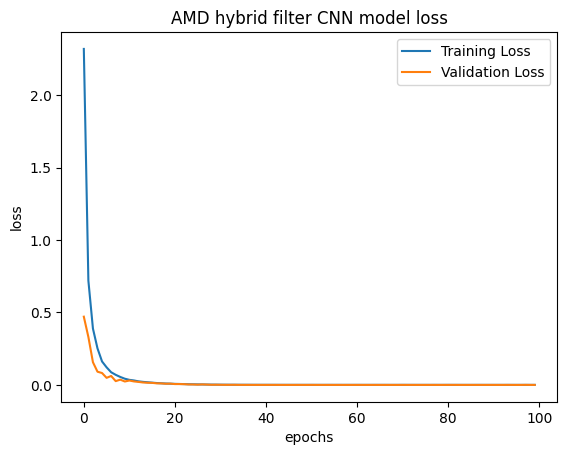

In [33]:

#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} hybrid filter CNN model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

In [34]:
# Save the entire model as a `.keras` zip archive.
best_model.save(f'saved_model_CNN/{ticker}_model_{study_naam}')

# Save the weights
# model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
# model = create_model()

# Restore the weights
# model.load_weights('./checkpoints/my_checkpoint')

INFO:tensorflow:Assets written to: saved_model_CNN/AMD_model_hybrid/assets


INFO:tensorflow:Assets written to: saved_model_CNN/AMD_model_hybrid/assets


In [35]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['org_akam']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="CNN"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

****************************TEST************************************
